In [2]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 6.2 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import yfinance as yf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Visual description of your preferred stock

Number of rows and columns after removing missing values: (2068, 7)
The time series starts from:  2013-12-16 00:00:00
The time series ends on:  2022-03-03 00:00:00
Statistics=276.277, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 0.03598642037159561
Skewness of normal distribution: 1.0778962381278583


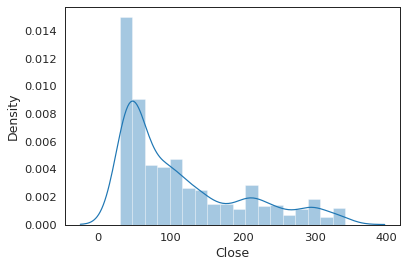

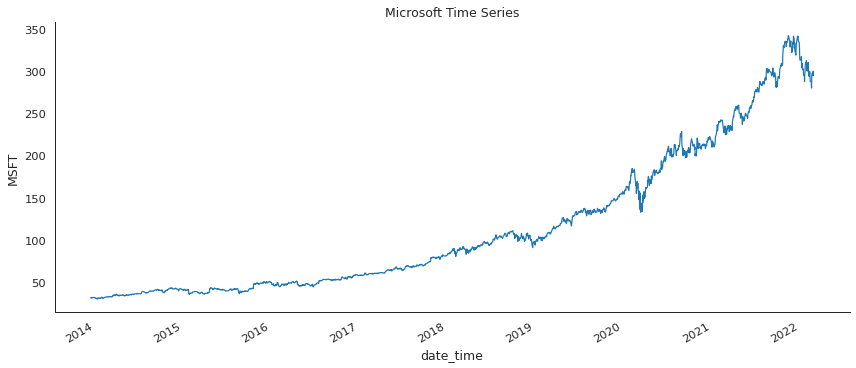

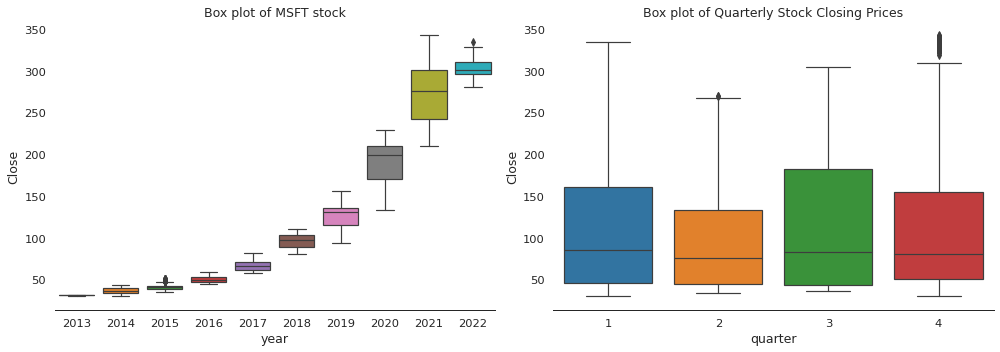

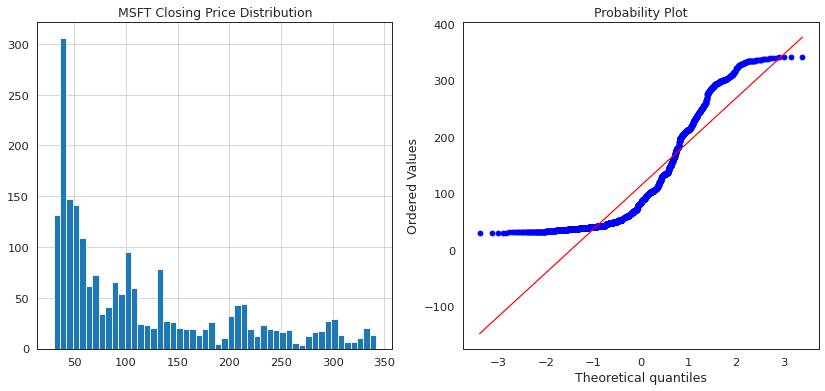

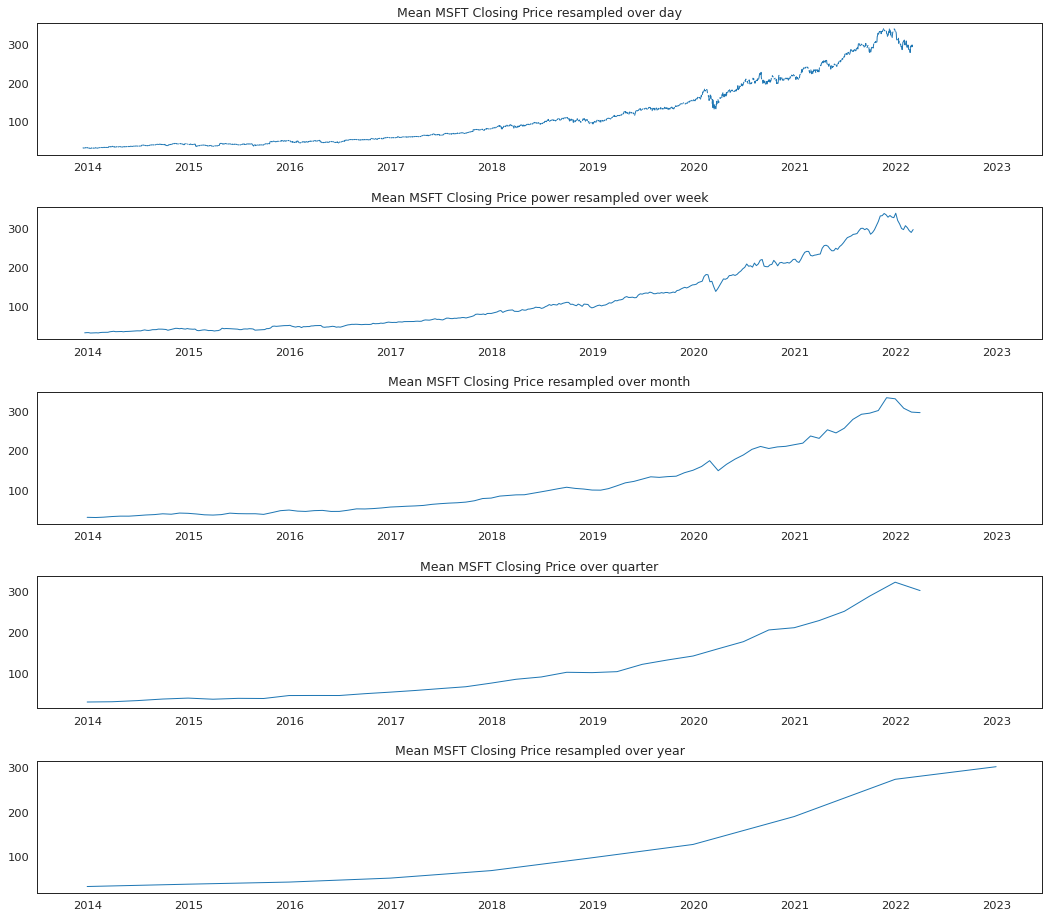

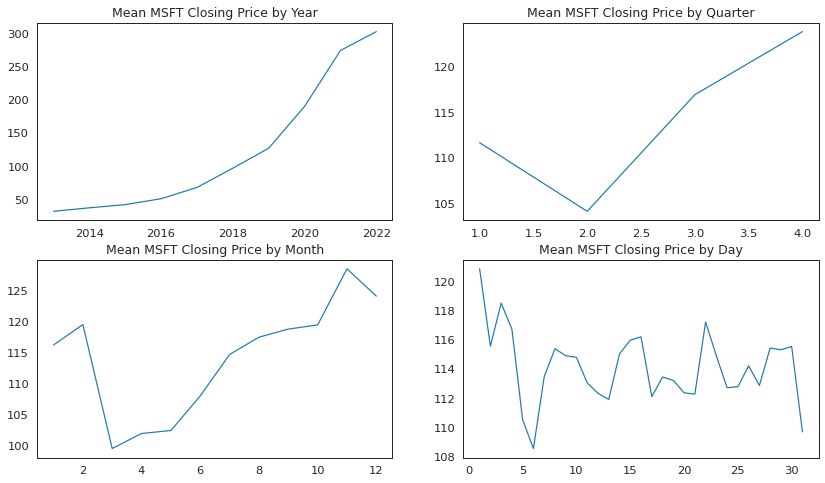

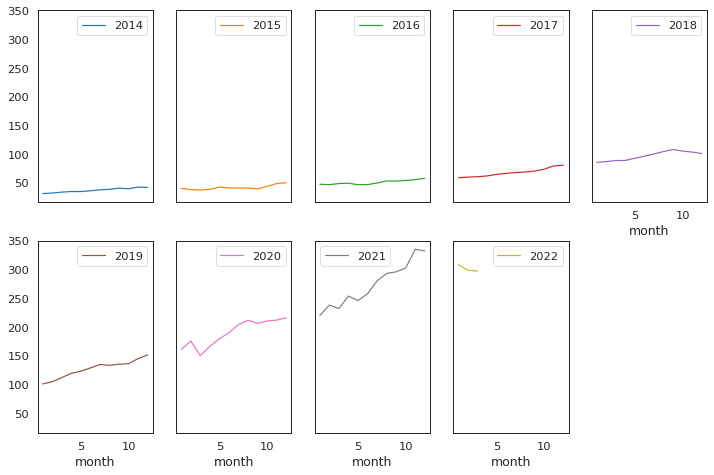

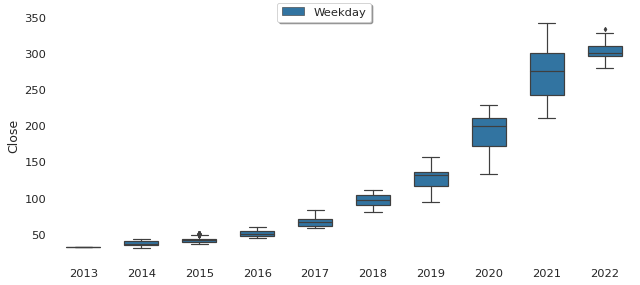

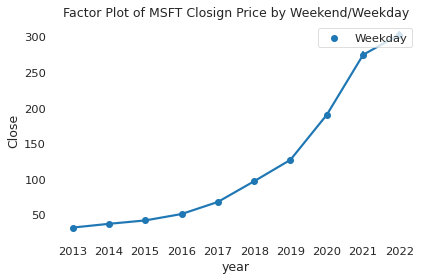

In [ ]:
msft = yf.Ticker("MSFT")
df = msft.history(period="max")
df = df.iloc[7000:]
df = df.reset_index()

df['date_time'] = df['Date']
df = df.dropna()
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Close', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

stat, p = stats.normaltest(df.Close)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

sns.distplot(df.Close);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Close)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Close)))

df1=df.loc[:,['date_time','Close']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('MSFT')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Microsoft Time Series')
sns.despine(top=True)
plt.show();

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Close", data=df)
plt.xlabel('year')
plt.title('Box plot of MSFT stock')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Close", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Stock Closing Prices')
sns.despine(left=True)
plt.tight_layout();

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Close'].hist(bins=50)
plt.title('MSFT Closing Price Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Close'], plot=plt);
df1.describe().T

fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Close'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean MSFT Closing Price resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Close'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean MSFT Closing Price power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Close'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean MSFT Closing Price resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Close'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean MSFT Closing Price over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Close'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean MSFT Closing Price resampled over year')
ax5.tick_params(axis='both', which='major');

plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean MSFT Closing Price by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean MSFT Closing Price by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean MSFT Closing Price by Month')

plt.subplot(2,2,4)
df.groupby('day').Close.agg('mean').plot()
plt.xlabel('')
plt.title('Mean MSFT Closing Price by Day');


pd.pivot_table(df.loc[df['year'] != 2013], values = "Close", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Close',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

plt1=sns.factorplot('year','Close',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of MSFT Closign Price by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');


Scraping companiesmarketcap.com for top 100 companies per industry by market cap (for the explanatory)

In [4]:
urls = [
    'https://companiesmarketcap.com/automakers/largest-automakers-by-market-cap/',
    'https://companiesmarketcap.com/automakers/largest-automakers-by-market-cap/',
    'https://companiesmarketcap.com/airlines/largest-airlines-by-market-cap/',
    'https://companiesmarketcap.com/airports/largest-airport-operating-companies-by-market-cap/',
    'https://companiesmarketcap.com/aircraft-manufacturers/largest-aircraft-manufacturers-by-market-cap/',
    'https://companiesmarketcap.com/banks/largest-banks-by-market-cap/',
    'https://companiesmarketcap.com/hotels/largest-hotel-companies-by-market-cap/',
    'https://companiesmarketcap.com/pharmaceuticals/largest-pharmaceutical-companies-by-market-cap/',
    'https://companiesmarketcap.com/e-commerce/largest-e-commerce-companies-by-market-cap/',
    'https://companiesmarketcap.com/healthcare/largest-healthcare-companies-by-market-cap/',
    'https://companiesmarketcap.com/ports/largest-port-operating-companies-by-market-cap/',
    'https://companiesmarketcap.com/professional-services/largest-professional-service-companies-by-market-cap/',
    'https://companiesmarketcap.com/food/largest-food-companies-by-market-cap/',
    'https://companiesmarketcap.com/restaurant-chains/largest-restaurant-chain-companies-by-market-cap/',
    'https://companiesmarketcap.com/software/largest-software-companies-by-market-cap/',
    'https://companiesmarketcap.com/semiconductors/largest-semiconductor-companies-by-market-cap/',
    'https://companiesmarketcap.com/tobacco/largest-tobacco-companies-by-market-cap/',
    'https://companiesmarketcap.com/financial-services/largest-financial-service-companies-by-market-cap/',
    'https://companiesmarketcap.com/oil-gas/largest-oil-and-gas-companies-by-market-cap/',
    'https://companiesmarketcap.com/electricity/largest-electricity-companies-by-market-cap/',
    'https://companiesmarketcap.com/delivery-services/largest-delivery-companies-by-market-cap/',
    'https://companiesmarketcap.com/media-press/largest-media-and-press-companies-by-market-cap/',
    'https://companiesmarketcap.com/alcoholic-beverages/largest-alcoholic-beverage-companies-by-market-cap/',
    'https://companiesmarketcap.com/beverages/largest-beverage-companies-by-market-cap/',
    'https://companiesmarketcap.com/clothing/largest-clothing-companies-by-market-cap/',
    'https://companiesmarketcap.com/mining/largest-mining-companies-by-market-cap/',
    'https://companiesmarketcap.com/railways/largest-railways-companies-by-market-cap/',
    'https://companiesmarketcap.com/insurance/largest-insurance-companies-by-market-cap/',
    'https://companiesmarketcap.com/real-estate/largest-real-estate-companies-by-market-cap/',
    'https://companiesmarketcap.com/chemicals/largest-chemical-companies-by-market-cap/',
    'https://companiesmarketcap.com/investment/largest-investment-companies-by-market-cap/',
    'https://companiesmarketcap.com/telecommunication/largest-telecommunication-companies-by-market-cap/',
    'https://companiesmarketcap.com/retail/largest-retail-companies-by-market-cap/',
    'https://companiesmarketcap.com/internet/largest-internet-companies-by-market-cap/',
    'https://companiesmarketcap.com/construction/largest-construction-companies-by-market-cap/',
    'https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/'
]
a = []
for x in range(len(urls)):
    a.append(urls[x].split('/')[3])
a

import requests
import time
import bs4
from bs4 import BeautifulSoup
cats = ['automakers','airlines','aircraft-manufacturers','banks','pharmaceuticals','e-commerce','healthcare','ports','professional-services','food','restaurant-chains','software','semiconductors','tobacco','financial-services','electricity','courier-services','media/press','alcoholic-beverages','beverages','clothing','mining','railways','insurance','real-estate','chemicals','investment','telecomunication','retail','internet','construction','tech']
cat_names = {'category':[],'names':[],'ticker':[]}
try:
    for x in range(len(urls)):
        url = urls[x]
        html = requests.get(url).text
        soup = bs4.BeautifulSoup(html, "html.parser")
        for tag in soup.findAll("div", {"class": "name-div"}):
                cat_names['names'].append(tag.findNext("div").text)
                cat_names['category'].append(a[x])
        for tag in soup.findAll("div", {"class": "company-name"}):
                cat_names['ticker'].append(tag.findNext().text)

except:
    print(x)


cat_names = pd.DataFrame(cat_names)
tech = cat_names['ticker'][cat_names['category']=='tech']

for x in range(len(tech)):
      xx  = yf.Ticker(tech.iloc[x])
      df = xx.history(period="max")
      df = df.drop(columns = ['Volume','Stock Splits','Dividends'])
      df.columns.values[0] = tech.iloc[x]+" Open"
      df.columns.values[1] = tech.iloc[x]+" High"
      df.columns.values[2] = tech.iloc[x]+" Low"
      df.columns.values[3] = tech.iloc[x]+" Close"
      tech.iloc[x] = df.reset_index()
tech.iloc[1]

,Date,MSFT Open,MSFT High,MSFT Low,MSFT Close
0,1986-03-13,0.0558,0.0640,0.0558,0.0613
1,1986-03-14,0.0613,0.0645,0.0613,0.0634
2,1986-03-17,0.0634,0.0651,0.0634,0.0645
3,1986-03-18,0.0645,0.0651,0.0623,0.0629
4,1986-03-19,0.0629,0.0634,0.0613,0.0618
...,...,...,...,...,...
9068,2022-03-04,294.2900,295.6600,287.1700,289.8600
9069,2022-03-07,288.5300,289.6900,278.5300,278.9100
9070,2022-03-08,277.8000,283.9600,270.0000,275.8500
9071,2022-03-09,283.4400,289.6000,280.7800,288.5000


In [5]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

no ABNB
no SNOW
no COIN
no XIACF
no 1024.HK
no CPNG
no DASH
no GFS


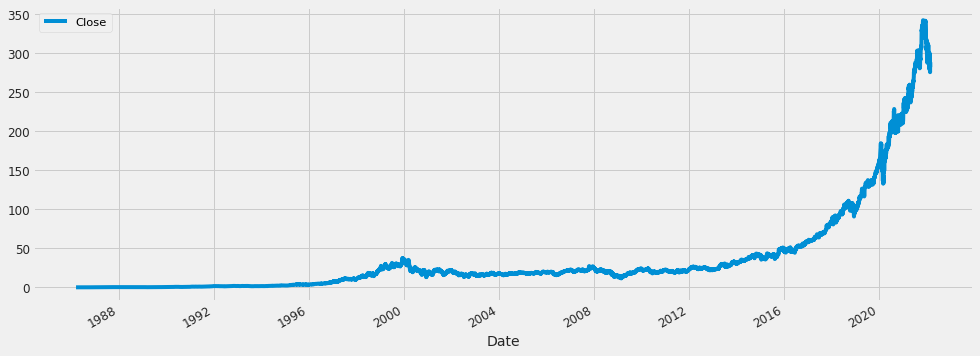

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0007   6.36e-05   1.57e+04      0.000       1.001       1.001
ar.S.L12       0.0549      0.003     18.994      0.000       0.049       0.061
sigma2         1.4705      0.004    352.743      0.000       1.462       1.479


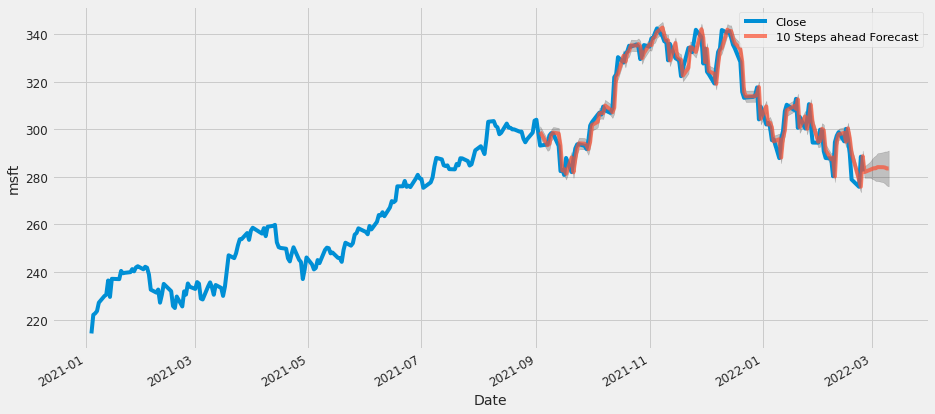

In [39]:
ticker = 'msft'
shift = -10
start_date = '2021-09-03'

msft = yf.Ticker(ticker)
df = msft.history(period="max")

for ii in range(99):
  if len(tech.iloc[ii])>500:
    pd.merge(df, tech.iloc[ii] ,on = 'Date')
  else:
    print('no '+tech.iloc[ii].columns[3].split()[0])

df = df.reset_index()
df = df.drop(columns = ['High','Low','Open','Volume'])
label = 'Close'
y = df[['Date',label]]
y['Date']=pd.to_datetime(y['Date'])
y = y.set_index('Date')
y = y.shift(shift)


y.plot(figsize=(15, 6))
plt.show()
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
#xxx = shift
mod = sm.tsa.statespace.SARIMAX(y,
                              order=(1, 0, 0),
                              seasonal_order=(1, 0, 0, 12),
                              enforce_stationarity=False,
                              enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

pred = results.get_prediction(start=start_date,dynamic=False)
pred_ci = pred.conf_int()
ax = y['2021':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label=str(shift*-1)+' Steps ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
              pred_ci.iloc[:, 0],
              pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel(str(ticker))
plt.legend()
plt.show()

SCRAP YARD (CONNECTING TO GOOGLE SHEETS TO ITERATE STOCKS / VARIABLES)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [ ]:
from google.colab import auth
auth.authenticate_user()
import requests
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
from gspread_dataframe import set_with_dataframe
sheetname="stonks" # Enter Sheet name without using extention


In [ ]:
urls = [
    'https://companiesmarketcap.com/automakers/largest-automakers-by-market-cap/',
    'https://companiesmarketcap.com/automakers/largest-automakers-by-market-cap/',
    'https://companiesmarketcap.com/airlines/largest-airlines-by-market-cap/',
    'https://companiesmarketcap.com/airports/largest-airport-operating-companies-by-market-cap/',
    'https://companiesmarketcap.com/aircraft-manufacturers/largest-aircraft-manufacturers-by-market-cap/',
    'https://companiesmarketcap.com/banks/largest-banks-by-market-cap/',
    'https://companiesmarketcap.com/hotels/largest-hotel-companies-by-market-cap/',
    'https://companiesmarketcap.com/pharmaceuticals/largest-pharmaceutical-companies-by-market-cap/',
    'https://companiesmarketcap.com/e-commerce/largest-e-commerce-companies-by-market-cap/',
    'https://companiesmarketcap.com/healthcare/largest-healthcare-companies-by-market-cap/',
    'https://companiesmarketcap.com/ports/largest-port-operating-companies-by-market-cap/',
    'https://companiesmarketcap.com/professional-services/largest-professional-service-companies-by-market-cap/',
    'https://companiesmarketcap.com/food/largest-food-companies-by-market-cap/',
    'https://companiesmarketcap.com/restaurant-chains/largest-restaurant-chain-companies-by-market-cap/',
    'https://companiesmarketcap.com/software/largest-software-companies-by-market-cap/',
    'https://companiesmarketcap.com/semiconductors/largest-semiconductor-companies-by-market-cap/',
    'https://companiesmarketcap.com/tobacco/largest-tobacco-companies-by-market-cap/',
    'https://companiesmarketcap.com/financial-services/largest-financial-service-companies-by-market-cap/',
    'https://companiesmarketcap.com/oil-gas/largest-oil-and-gas-companies-by-market-cap/',
    'https://companiesmarketcap.com/electricity/largest-electricity-companies-by-market-cap/',
    'https://companiesmarketcap.com/delivery-services/largest-delivery-companies-by-market-cap/',
    'https://companiesmarketcap.com/media-press/largest-media-and-press-companies-by-market-cap/',
    'https://companiesmarketcap.com/alcoholic-beverages/largest-alcoholic-beverage-companies-by-market-cap/',
    'https://companiesmarketcap.com/beverages/largest-beverage-companies-by-market-cap/',
    'https://companiesmarketcap.com/clothing/largest-clothing-companies-by-market-cap/',
    'https://companiesmarketcap.com/mining/largest-mining-companies-by-market-cap/',
    'https://companiesmarketcap.com/railways/largest-railways-companies-by-market-cap/',
    'https://companiesmarketcap.com/insurance/largest-insurance-companies-by-market-cap/',
    'https://companiesmarketcap.com/real-estate/largest-real-estate-companies-by-market-cap/',
    'https://companiesmarketcap.com/chemicals/largest-chemical-companies-by-market-cap/',
    'https://companiesmarketcap.com/investment/largest-investment-companies-by-market-cap/',
    'https://companiesmarketcap.com/telecommunication/largest-telecommunication-companies-by-market-cap/',
    'https://companiesmarketcap.com/retail/largest-retail-companies-by-market-cap/',
    'https://companiesmarketcap.com/internet/largest-internet-companies-by-market-cap/',
    'https://companiesmarketcap.com/construction/largest-construction-companies-by-market-cap/',
    'https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/'
]
a = []
for x in range(len(urls)):
    a.append(urls[x].split('/')[3])
a

import requests
import time
import bs4
from bs4 import BeautifulSoup
cats = ['automakers','airlines','aircraft-manufacturers','banks','pharmaceuticals','e-commerce','healthcare','ports','professional-services','food','restaurant-chains','software','semiconductors','tobacco','financial-services','electricity','courier-services','media/press','alcoholic-beverages','beverages','clothing','mining','railways','insurance','real-estate','chemicals','investment','telecomunication','retail','internet','construction','tech']
cat_names = {'category':[],'names':[],'ticker':[]}
try:
    for x in range(len(urls)):
        url = urls[x]
        html = requests.get(url).text
        soup = bs4.BeautifulSoup(html, "html.parser")
        for tag in soup.findAll("div", {"class": "name-div"}):
                cat_names['names'].append(tag.findNext("div").text)
                cat_names['category'].append(a[x])
        for tag in soup.findAll("div", {"class": "company-name"}):
                cat_names['ticker'].append(tag.findNext().text)

        time.sleep(3)
except:
    print(x)

In [10]:
for i in range(10000):
  sh = gc.open(sheetname)
  worksheet = sh.sheet1
  values_list = worksheet.get_all_values()
  dff = pd.DataFrame(values_list)
  company = dff[0][9]
  time.sleep(3)
  if company =='1':
    try:
      tech = cat_names['ticker'][cat_names['category']==dff[1][2]]

      for x in range(len(tech)):
            xx  = yf.Ticker(tech.iloc[x])
            df = xx.history(period="max")
            df.columns.values[0] = tech.iloc[x]+" Open"
            df.columns.values[1] = tech.iloc[x]+" High"
            df.columns.values[2] = tech.iloc[x]+" Low"
            df.columns.values[3] = tech.iloc[x]+" Close"
            tech.iloc[x] = df.reset_index()
      
      msft = yf.Ticker(dff[1][1])
      df = msft.history(period="max")
      df = pd.merge(df, tech.iloc[1] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[2] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[3] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[4] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[5] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[6] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[7] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[8] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[9] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[10] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[11] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[12] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[13] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[14] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[15] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[16] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[17] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[18] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[19] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[20] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[21] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[22] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[23] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[24] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[25] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[26] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[27] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[28] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[30] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[31] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[32] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[33] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[34] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[35] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[36] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[37] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[38] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[39] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[40] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[41] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[42] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[43] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[44] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[45] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[46] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[47] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[48] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[49] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[50] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[51] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[52] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[53] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[54] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[55] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[56] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[57] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[58] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[59] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[60] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[61] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[62] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[63] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[64] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[65] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[66] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[67] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[68] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[69] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[70] ,on = 'Date')
      df = pd.merge(df,  tech.iloc[71] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[72] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[73] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[74] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[75] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[76] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[77] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[78] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[79] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[80] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[81] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[82] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[83] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[84] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[85] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[86] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[87] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[88] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[89] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[90] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[91] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[92] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[93] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[94] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[95] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[96] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[97] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[98] ,on = 'Date')
      #df = pd.merge(df,  tech.iloc[99] ,on = 'Date')
    except:
      print()
    df = df.reset_index()
    df = df.drop(columns = ['High','Low','Open','Volume','Volume_x'])
    label = 'Close'
    y = df[['Date',label]]
    y['Date']=pd.to_datetime(y['Date'])
    y = y.set_index('Date')



    y.plot(figsize=(15, 6))
    plt.show()
    from pylab import rcParams
    rcParams['figure.figsize'] = 18, 8
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    print('Examples of parameter combinations for Seasonal ARIMA...')
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
    xxx = int(dff[1][5])*-1
    mod = sm.tsa.statespace.SARIMAX(y.shift(xxx),
                                    order=(1, 0, 0),
                                    seasonal_order=(1, 0, 0, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])

    pred = results.get_prediction(start=dff[1][4],dynamic=False)
    pred_ci = pred.conf_int()
    ax = y['2021':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel(str(dff[1][0]))
    plt.legend()
    plt.savefig(f"{images_dir}/abc.png")
    plt.show()

    time.sleep(5)


NameError: ignored

In [ ]:


#%% Forecast 1y
years = 1
pred_uc = results.get_forecast(steps=12*years)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy')
plt.legend()
plt.show()
plt.savefig(current_dir + os.sep + 'SARIMAX_FORECAST_1y.png')
plt.close()

#%% Forecast 5y
years = 5
pred_uc = results.get_forecast(steps=12*years)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy')
plt.legend()
plt.show()
plt.savefig(current_dir + os.sep + 'SARIMAX_FORECAST_5y.png')
plt.close()

ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f671af1fcb0> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 1008x504 with 1 Axes>

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 0.1311 - val_loss: 0.6531
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1267 - val_loss: 0.6396
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 0.1229 - val_loss: 0.6262
Epoch 4/100
1/1 [==============================] - 0s 34ms/step - loss: 0.1193 - val_loss: 0.6130
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 0.1163 - val_loss: 0.6000
Epoch 6/100
1/1 [==============================] - 0s 57ms/step - loss: 0.1115 - val_loss: 0.5871
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 0.1077 - val_loss: 0.5743
Epoch 8/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1040 - val_loss: 0.5617
Epoch 9/100
1/1 [==============================] - 0s 34ms/step - loss: 0.1005 - val_loss: 0.5493
Epoch 10/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0977 - val_loss: 0.5369
Epoch 11/100
1/1 [===

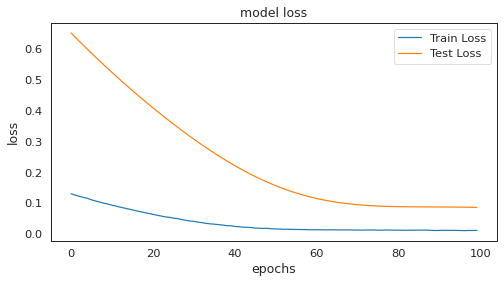

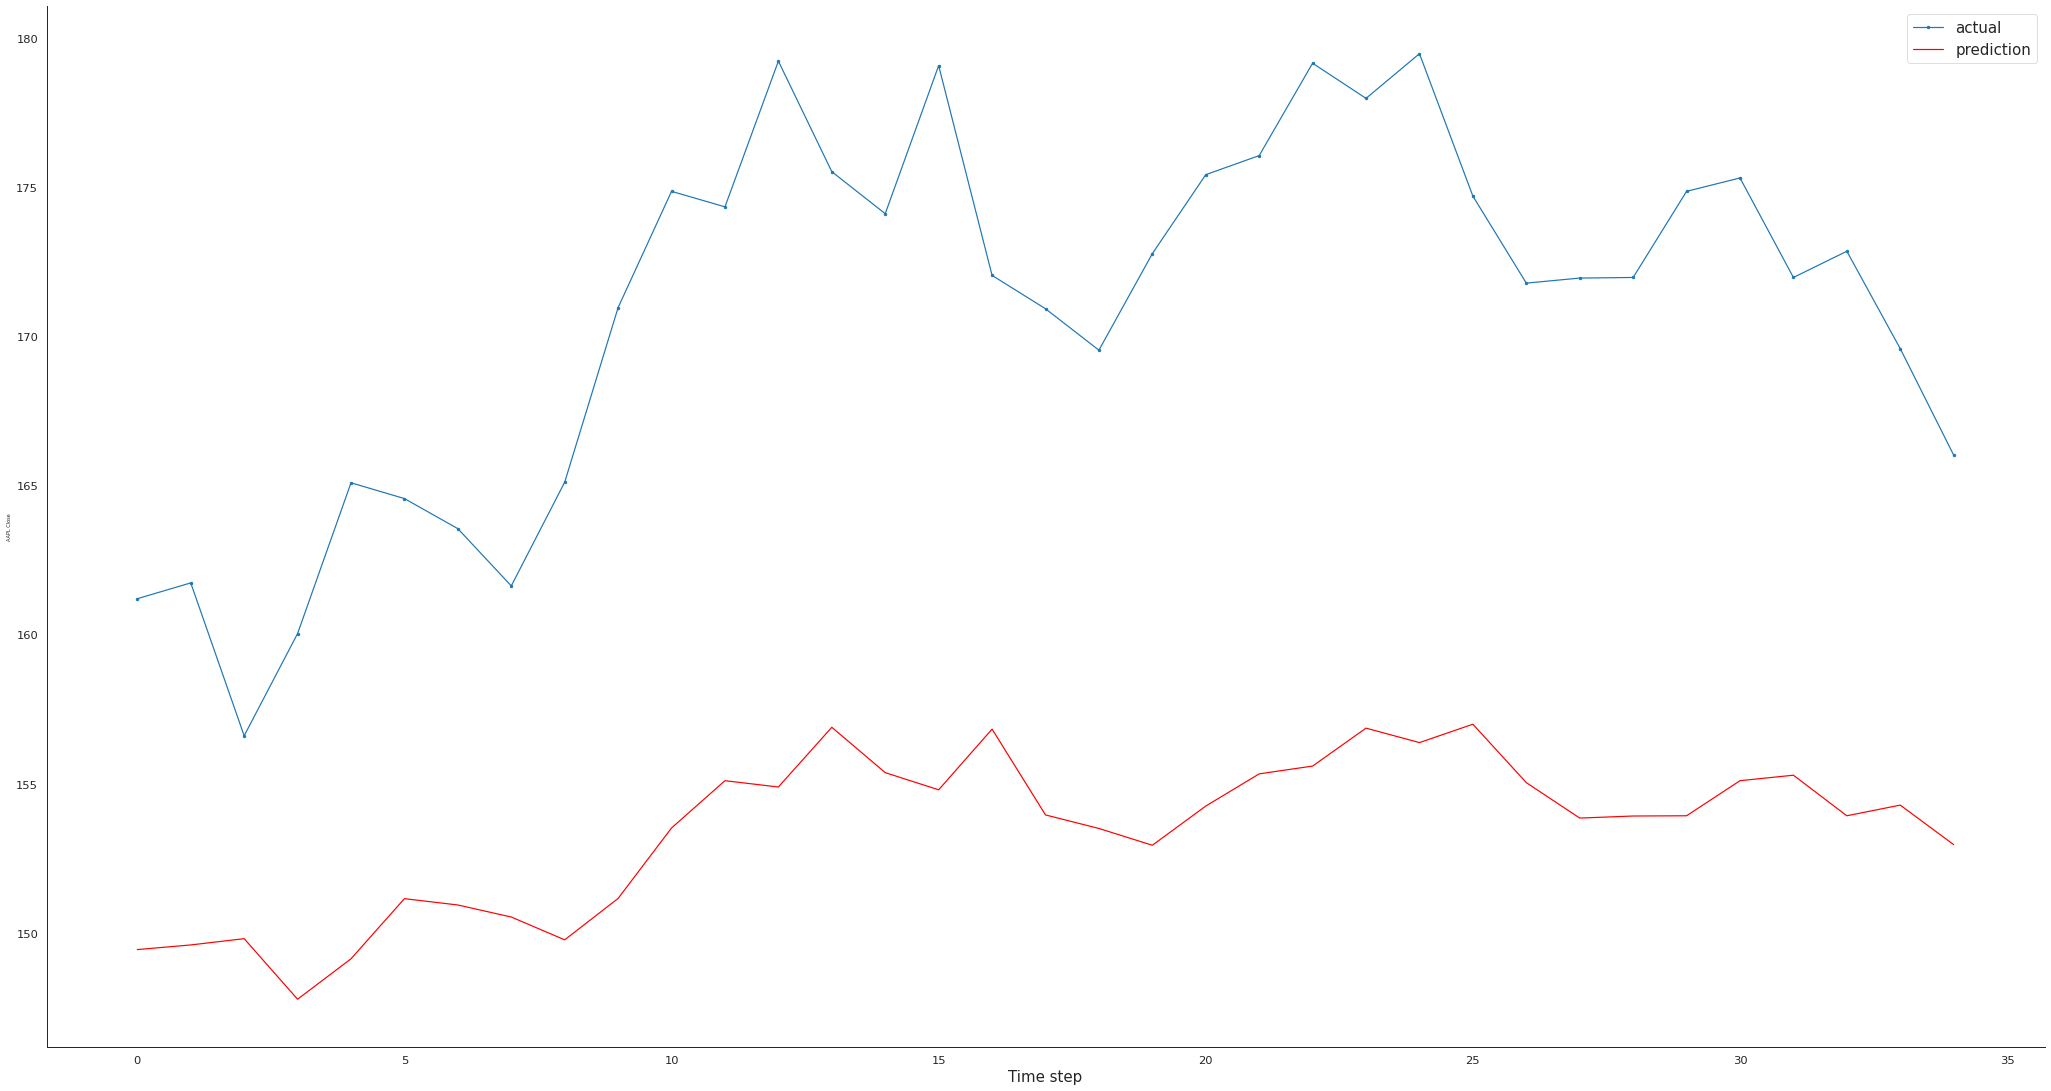

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2806 - val_loss: 0.5914
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 0.2749 - val_loss: 0.5793
Epoch 3/100
1/1 [==============================] - 0s 32ms/step - loss: 0.2667 - val_loss: 0.5673
Epoch 4/100
1/1 [==============================] - 0s 52ms/step - loss: 0.2591 - val_loss: 0.5555
Epoch 5/100
1/1 [==============================] - 0s 45ms/step - loss: 0.2551 - val_loss: 0.5439
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 0.2496 - val_loss: 0.5324
Epoch 7/100
1/1 [==============================] - 0s 39ms/step - loss: 0.2431 - val_loss: 0.5210
Epoch 8/100
1/1 [==============================] - 0s 43ms/step - loss: 0.2377 - val_loss: 0.5098
Epoch 9/100
1/1 [==============================] - 0s 37ms/step - loss: 0.2308 - val_loss: 0.4987
Epoch 10/100
1/1 [==============================] - 0s 37ms/step - loss: 0.2255 - val_loss: 0.4877
Epoch 11/100
1/1 [===

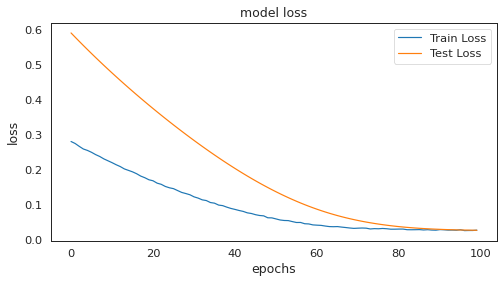

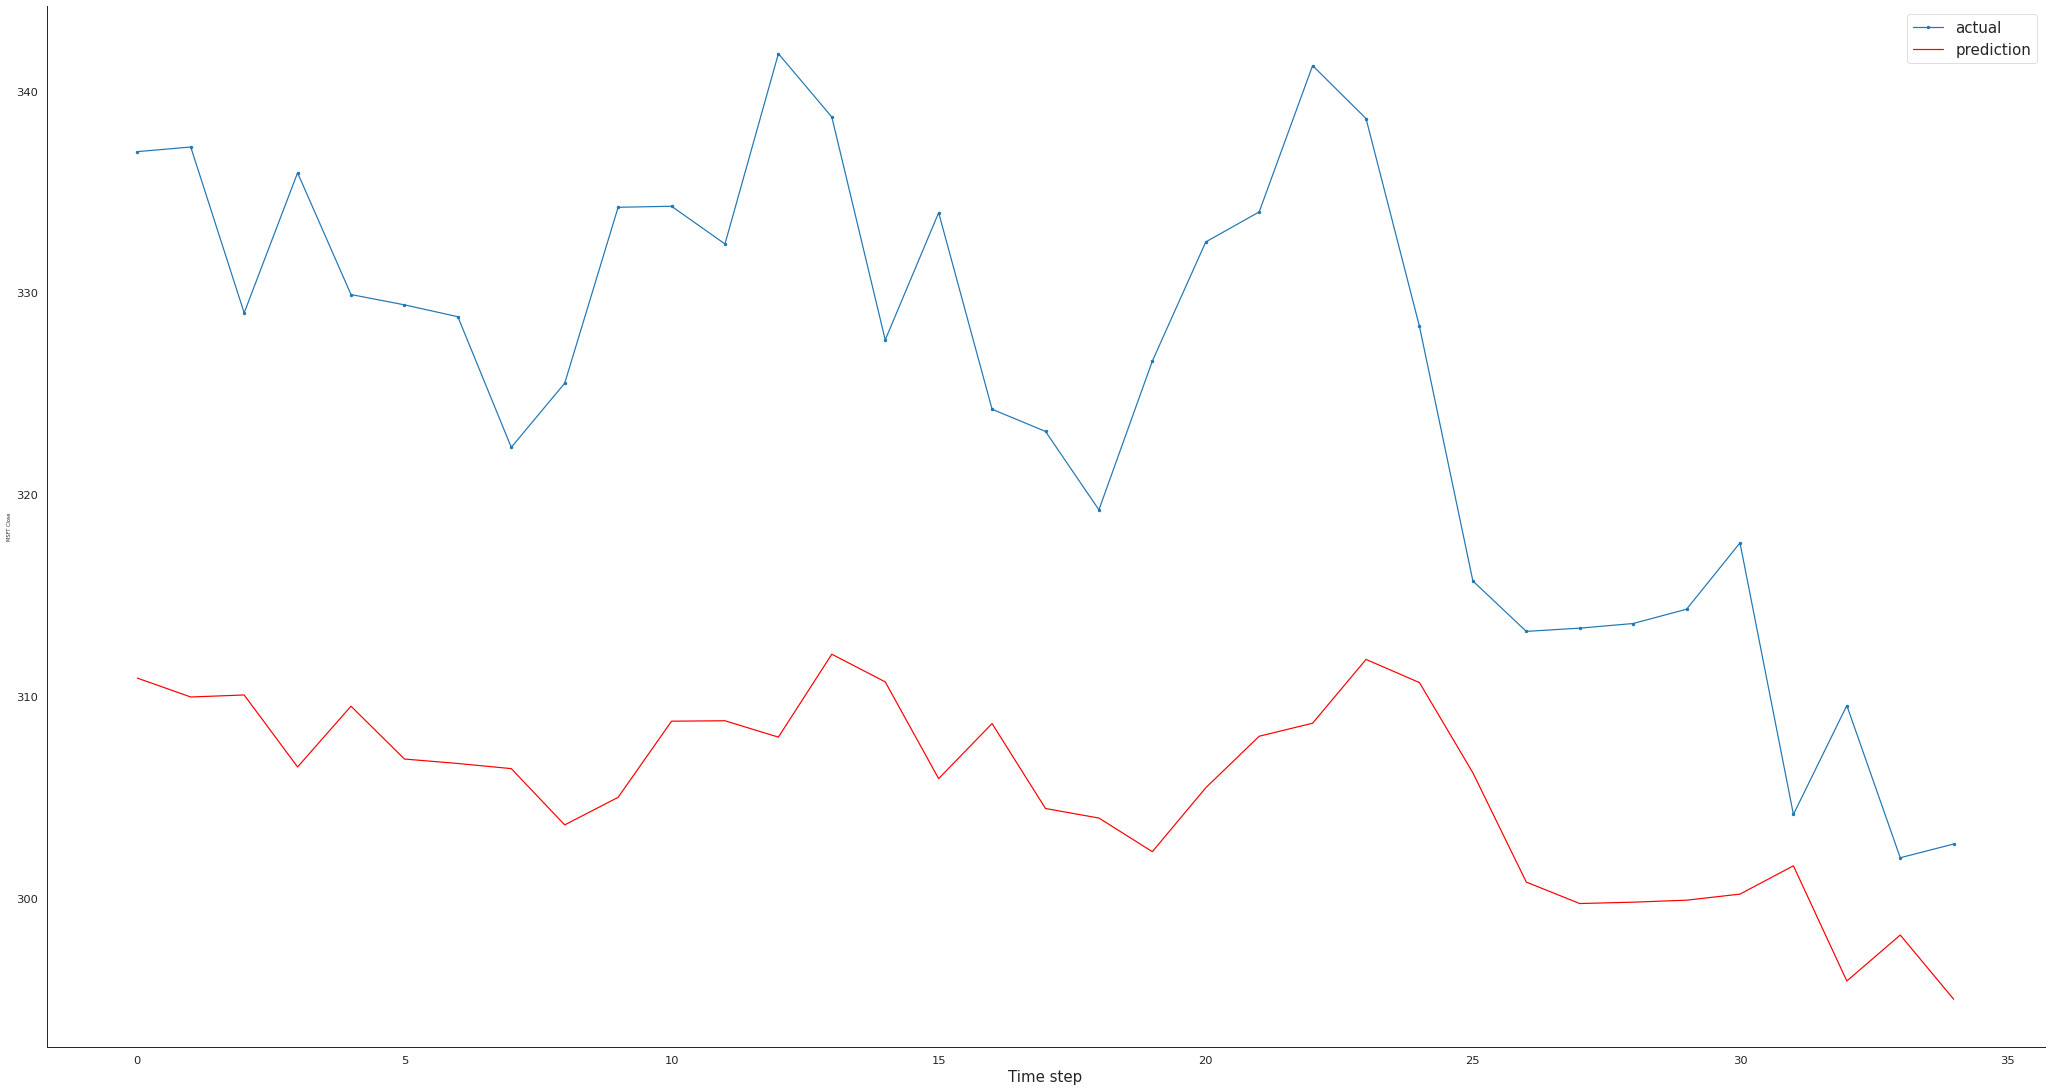

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.1689 - val_loss: 0.3056
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1626 - val_loss: 0.2979
Epoch 3/100
1/1 [==============================] - 0s 32ms/step - loss: 0.1581 - val_loss: 0.2903
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 0.1537 - val_loss: 0.2828
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 0.1483 - val_loss: 0.2754
Epoch 6/100
1/1 [==============================] - 0s 32ms/step - loss: 0.1429 - val_loss: 0.2681
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1385 - val_loss: 0.2609
Epoch 8/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1336 - val_loss: 0.2539
Epoch 9/100
1/1 [==============================] - 0s 34ms/step - loss: 0.1293 - val_loss: 0.2469
Epoch 10/100
1/1 [==============================] - 0s 32ms/step - loss: 0.1250 - val_loss: 0.2401
Epoch 11/100
1/1 [===

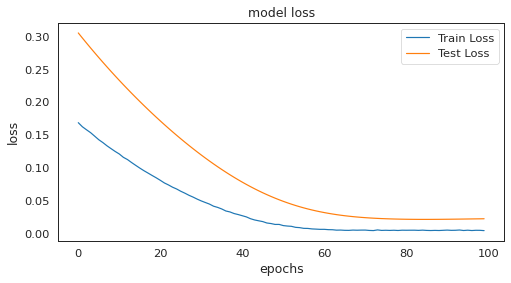

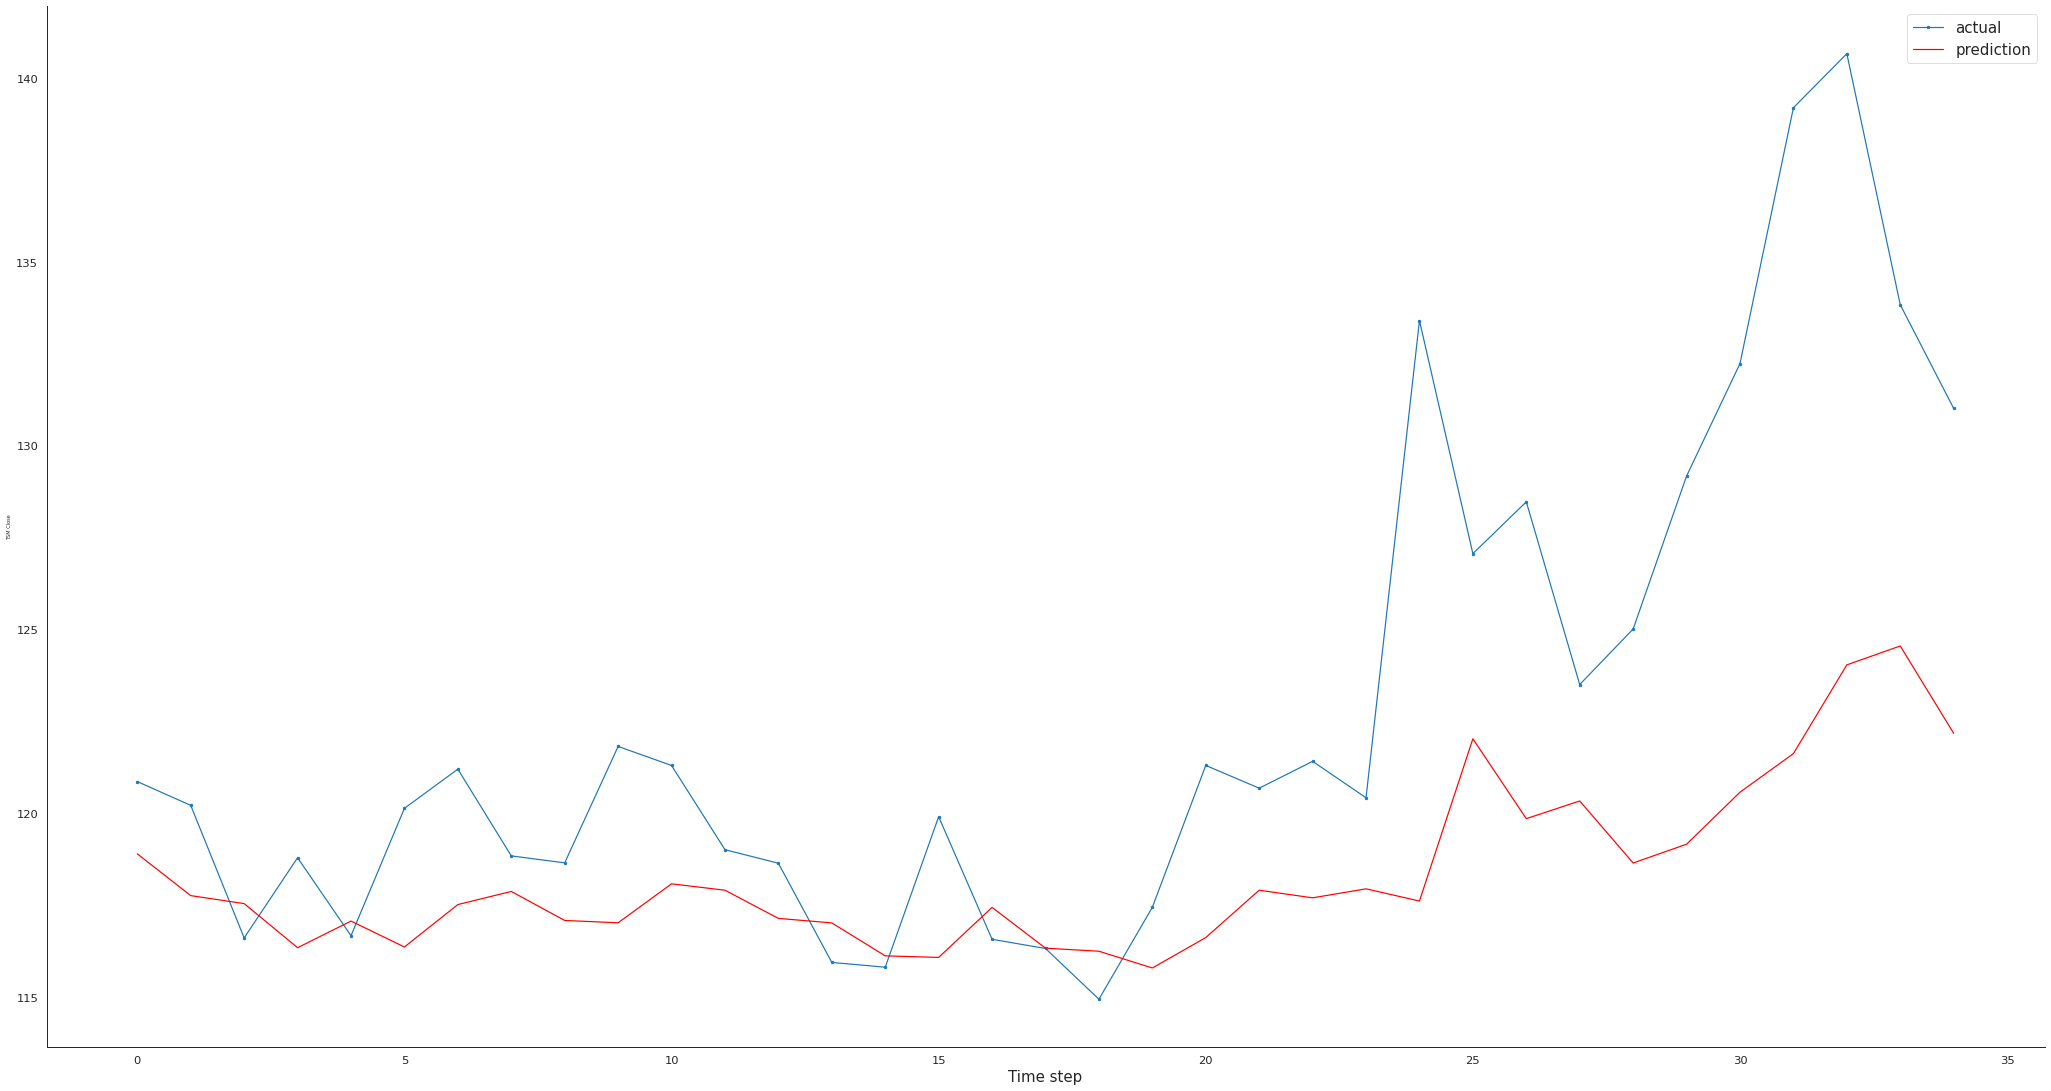

In [9]:
ss = {'train':[],'test':[]}
stocks = [4,8,24]
for x in stocks:
  df = pd.merge(tech.iloc[0], tech.iloc[1] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[2] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[3] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[4] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[5] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[6] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[7] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[8] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[9] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[10] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[11] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[12] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[13] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[14] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[15] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[16] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[17] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[18] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[19] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[20] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[21] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[22] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[23] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[24] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[25] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[26] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[27] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[28] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[30] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[31] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[32] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[33] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[34] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[35] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[36] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[37] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[38] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[39] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[40] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[41] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[42] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[43] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[44] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[45] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[46] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[47] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[48] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[49] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[50] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[51] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[52] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[53] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[54] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[55] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[56] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[57] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[58] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[59] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[60] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[61] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[62] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[63] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[64] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[65] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[66] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[67] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[68] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[69] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[70] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[71] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[72] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[73] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[74] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[75] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[76] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[77] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[78] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[79] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[80] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[81] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[82] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[83] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[84] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[85] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[86] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[87] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[88] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[89] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[90] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[91] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[92] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[93] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[94] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[95] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[96] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[97] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[98] ,on = 'Date')
  df = pd.merge(df,  tech.iloc[99] ,on = 'Date')

  label = df.columns[x]


  dataset = df[label].values #numpy.ndarray
  dataset = dataset.astype('float32')
  dataset = np.reshape(dataset, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  train_size = int(len(dataset) * 0.7)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  def create_dataset(dataset, look_back=2):
      X, Y = [], []
      for i in range(len(dataset)-look_back-1):
          a = dataset[i:(i+look_back), 0]
          X.append(a)
          Y.append(dataset[i + look_back, 0])
      return np.array(X), np.array(Y)

  look_back = 1
  X_train, Y_train = create_dataset(train, look_back)
  X_test, Y_test = create_dataset(test, look_back)

  # reshape input to be [samples, time steps, features]
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


  model = Sequential()
  model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  history = model.fit(X_train, Y_train, epochs=100, batch_size=500, validation_data=(X_test, Y_test), 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=100)], verbose=1, shuffle=False)

  model.summary()

  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  # invert predictions
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])
  test_predict = scaler.inverse_transform(test_predict)
  Y_test = scaler.inverse_transform([Y_test])
  ss['train'].append(mean_absolute_error(Y_train[0], train_predict[:,0]))
  ss['test'].append(mean_absolute_error(Y_test[0], test_predict[:,0]))

  print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
  print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
  print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
  print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))


  plt.figure(figsize=(8,4))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Test Loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(loc='upper right')
  plt.show();


  aa=[x for x in range(35)]
  plt.figure(figsize=(30,15))
  plt.plot(aa, Y_test[0][:35], marker='.', label="actual")
  plt.plot(aa, test_predict[:,0][:35], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.ylabel(label, size=5)
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show();


In [ ]:
y

,Close
Date,
2021-04-14,694.4000
2021-04-15,677.0000
2021-04-16,684.9000
2021-04-19,673.6000
2021-04-20,663.5400
...,...
2022-02-23,NaN
2022-02-24,NaN
2022-02-25,NaN


In [ ]:
df['Close'].shift(-10)

0     694.4000
1     677.0000
2     684.9000
3     673.6000
4     663.5400
        ...   
199        NaN
200        NaN
201        NaN
202        NaN
203        NaN
Name: Close, Length: 204, dtype: float64

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import deque

import os
import numpy as np
import pandas as pd
import random


In [ ]:
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)


In [ ]:
df

,index,Date,Close,Volume_x,Dividends_x,Stock Splits_x,MSFT Open,MSFT High,MSFT Low,MSFT Close,...,COIN Close,Volume_y,Dividends_y,Stock Splits_y,DDOG Open,DDOG High,DDOG Low,DDOG Close,Dividends,Stock Splits
0,0,2021-04-14,732.2300,49017400,0,0.0000,255.3997,256.7387,253.0984,253.5249,...,328.2800,81065700,0,0,94.8900,96.1400,93.0000,93.2500,0,0
1,1,2021-04-15,738.8500,27848900,0,0.0000,255.8460,257.8299,255.6477,257.4034,...,322.7500,39777900,0,0,94.0400,96.3500,93.9300,95.2700,0,0
2,2,2021-04-16,739.7800,27979500,0,0.0000,257.3736,258.8912,255.5187,258.6333,...,342.0000,22654500,0,0,94.5490,94.6300,89.2800,90.3400,0,0
3,3,2021-04-19,714.6300,39686200,0,0.0000,258.0878,259.3674,255.7369,256.6495,...,333.0000,11405600,0,0,90.0100,91.7700,86.9000,87.8900,0,0
4,4,2021-04-20,718.9900,35609000,0,0.0000,255.7369,258.0977,254.7648,256.1734,...,320.8200,18082300,0,0,88.4000,88.4000,83.5700,83.9600,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,199,2022-02-23,764.0400,31752300,0,0.0000,290.1800,291.7000,280.1000,280.2700,...,172.7400,3892500,0,0,156.4450,158.9400,148.5000,149.4400,0,0
200,200,2022-02-24,800.7700,45107400,0,0.0000,272.5100,295.1600,271.5200,294.5900,...,179.5600,8134000,0,0,143.7500,160.5400,142.6300,159.8600,0,0
201,201,2022-02-25,809.8700,25355900,0,0.0000,295.1400,297.6300,291.6500,297.3100,...,176.8300,6836800,0,0,159.4400,161.6500,154.8700,161.4100,0,0
202,202,2022-03-02,879.8900,24881100,0,0.0000,295.3600,301.4700,293.7000,300.1900,...,194.5000,3414100,0,0,159.0000,165.0200,153.6200,164.4800,0,0


In [ ]:
feature_columns

['GOOG Low',
 'GOOG High',
 'GOOG Open',
 'Stock Splits_y',
 'Dividends_y',
 'Volume_y',
 'MSFT Close',
 'MSFT Low',
 'MSFT High',
 'MSFT Open',
 'Stock Splits_x',
 'Dividends_x',
 'Volume_x',
 'Close',
 'Date']

In [ ]:
df

0     732.2300
1     738.8500
2     739.7800
3     714.6300
4     718.9900
        ...   
199   764.0400
200   800.7700
201   809.8700
202   879.8900
203   839.2900
Name: Close, Length: 204, dtype: float64

feature_columns

In [ ]:

n_steps=50
scale=True
shuffle=True
lookup_step=1
split_by_date=True
test_size=0.2
feature_columns = [df.columns[15],df.columns[14],df.columns[13],df.columns[12],df.columns[38],df.columns[44],df.columns[32],df.columns[8],df.columns[7],df.columns[6],df.columns[5]]
# this will contain all the elements we want to return from this function
result = pd.DataFrame()
# we will also return the original dataframe itself
result['df'] = df['Close']
# make sure that the passed feature_columns exist in the dataframe
# add date as a column
df = df[20:]
if "date" not in df.columns:
    df["Date"] = df.index
if scale:
    column_scaler = {}
    # scale the data (prices) from 0 to 1
    for column in feature_columns:
        scaler = preprocessing.MinMaxScaler()
        df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
        column_scaler[column] = scaler
    # add the MinMaxScaler instances to the result returned
    result["column_scaler"] = column_scaler
# add the target column (label) by shifting by `lookup_step`
df['future'] = df['Close'].shift(-lookup_step)
# last `lookup_step` columns contains NaN in future column
# get them before droping NaNs
last_sequence = np.array(df[feature_columns].tail(lookup_step))
# drop NaNs
df.dropna(inplace=True)
sequence_data = []
sequences = deque(maxlen=n_steps)
for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
    sequences.append(entry)
    if len(sequences) == n_steps:
        sequence_data.append([np.array(sequences), target])
# get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
# for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
# this last_sequence will be used to predict future stock prices that are not available in the dataset
last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
last_sequence = np.array(last_sequence).astype(np.float32)
# add to result
result['last_sequence'] = last_sequence
# construct the X's and y's
X, y = [], []
for seq, target in sequence_data:
    X.append(seq)
    y.append(target)
# convert to numpy arrays
X = np.array(X)
y = np.array(y)
if split_by_date:
    # split the dataset into training & testing sets by date (not randomly splitting)
    train_samples = int((1 - test_size) * len(X))
    result["X_train"] = X[:train_samples]
    result["y_train"] = y[:train_samples]
    result["X_test"]  = X[train_samples:]
    result["y_test"]  = y[train_samples:]
    if shuffle:
        # shuffle the datasets for training (if shuffle parameter is set)
        shuffle_in_unison(result["X_train"], result["y_train"])
        shuffle_in_unison(result["X_test"], result["y_test"])
else:    
    # split the dataset randomly
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                            test_size=test_size, shuffle=shuffle)
# get the list of test set dates
dates = result["X_test"][:, -1, -1]
# retrieve test features from the original dataframe
result["test_df"] = result["df"].loc[dates]
# remove duplicated dates in the testing dataframe
result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
# remove dates from the training/testing sets & convert to float32
result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)


ValueError: ignored

In [ ]:
len(df['MSFT Open'].values)

184

In [ ]:
df

In [ ]:
msft = yf.Ticker('amzn')
df = msft.history(period="max")
df = pd.merge(df, tech.iloc[1] ,on = 'Date')
df = pd.merge(df,  tech.iloc[2] ,on = 'Date')
df = pd.merge(df,  tech.iloc[3] ,on = 'Date')
df = pd.merge(df,  tech.iloc[4] ,on = 'Date')
df = pd.merge(df,  tech.iloc[5] ,on = 'Date')
df = pd.merge(df,  tech.iloc[6] ,on = 'Date')
df = pd.merge(df,  tech.iloc[7] ,on = 'Date')
df = pd.merge(df,  tech.iloc[8] ,on = 'Date')
df = pd.merge(df,  tech.iloc[9] ,on = 'Date')
df = pd.merge(df,  tech.iloc[10] ,on = 'Date')
df = pd.merge(df,  tech.iloc[11] ,on = 'Date')
df = pd.merge(df,  tech.iloc[12] ,on = 'Date')
df = pd.merge(df,  tech.iloc[13] ,on = 'Date')
df = pd.merge(df,  tech.iloc[14] ,on = 'Date')
df = pd.merge(df,  tech.iloc[15] ,on = 'Date')
df = pd.merge(df,  tech.iloc[16] ,on = 'Date')
df = pd.merge(df,  tech.iloc[17] ,on = 'Date')
df = pd.merge(df,  tech.iloc[18] ,on = 'Date')
df = pd.merge(df,  tech.iloc[19] ,on = 'Date')
df = pd.merge(df,  tech.iloc[20] ,on = 'Date')
df = pd.merge(df,  tech.iloc[21] ,on = 'Date')
df = pd.merge(df,  tech.iloc[22] ,on = 'Date')
df = pd.merge(df,  tech.iloc[23] ,on = 'Date')
df = pd.merge(df,  tech.iloc[24] ,on = 'Date')
df = pd.merge(df,  tech.iloc[25] ,on = 'Date')
df = pd.merge(df,  tech.iloc[26] ,on = 'Date')
df = pd.merge(df,  tech.iloc[27] ,on = 'Date')
df = pd.merge(df,  tech.iloc[28] ,on = 'Date')
df = pd.merge(df,  tech.iloc[30] ,on = 'Date')
df = pd.merge(df,  tech.iloc[31] ,on = 'Date')
df = pd.merge(df,  tech.iloc[32] ,on = 'Date')
df = pd.merge(df,  tech.iloc[33] ,on = 'Date')
df = pd.merge(df,  tech.iloc[34] ,on = 'Date')
df = pd.merge(df,  tech.iloc[35] ,on = 'Date')
df = pd.merge(df,  tech.iloc[36] ,on = 'Date')
df = pd.merge(df,  tech.iloc[37] ,on = 'Date')
df = pd.merge(df,  tech.iloc[38] ,on = 'Date')
df = pd.merge(df,  tech.iloc[39] ,on = 'Date')
df = pd.merge(df,  tech.iloc[40] ,on = 'Date')
df = pd.merge(df,  tech.iloc[41] ,on = 'Date')
df = pd.merge(df,  tech.iloc[42] ,on = 'Date')
df = pd.merge(df,  tech.iloc[43] ,on = 'Date')
df = pd.merge(df,  tech.iloc[44] ,on = 'Date')
df = pd.merge(df,  tech.iloc[45] ,on = 'Date')
df = pd.merge(df,  tech.iloc[46] ,on = 'Date')
df = pd.merge(df,  tech.iloc[47] ,on = 'Date')
df = pd.merge(df,  tech.iloc[48] ,on = 'Date')
df = pd.merge(df,  tech.iloc[49] ,on = 'Date')
df = pd.merge(df,  tech.iloc[50] ,on = 'Date')
df = pd.merge(df,  tech.iloc[51] ,on = 'Date')
df = pd.merge(df,  tech.iloc[52] ,on = 'Date')
df = pd.merge(df,  tech.iloc[53] ,on = 'Date')
df = pd.merge(df,  tech.iloc[54] ,on = 'Date')
df = pd.merge(df,  tech.iloc[55] ,on = 'Date')
df = pd.merge(df,  tech.iloc[56] ,on = 'Date')
df = pd.merge(df,  tech.iloc[57] ,on = 'Date')
df = pd.merge(df,  tech.iloc[58] ,on = 'Date')
df = pd.merge(df,  tech.iloc[59] ,on = 'Date')
df = pd.merge(df,  tech.iloc[60] ,on = 'Date')
df = pd.merge(df,  tech.iloc[61] ,on = 'Date')
df = pd.merge(df,  tech.iloc[62] ,on = 'Date')
df = pd.merge(df,  tech.iloc[63] ,on = 'Date')
df = pd.merge(df,  tech.iloc[64] ,on = 'Date')
df = pd.merge(df,  tech.iloc[65] ,on = 'Date')
df = pd.merge(df,  tech.iloc[66] ,on = 'Date')
df = pd.merge(df,  tech.iloc[67] ,on = 'Date')
df = pd.merge(df,  tech.iloc[68] ,on = 'Date')
df = pd.merge(df,  tech.iloc[69] ,on = 'Date')
df = pd.merge(df,  tech.iloc[70] ,on = 'Date')
df = pd.merge(df,  tech.iloc[71] ,on = 'Date')
df = pd.merge(df,  tech.iloc[72] ,on = 'Date')
df = pd.merge(df,  tech.iloc[73] ,on = 'Date')
df = pd.merge(df,  tech.iloc[74] ,on = 'Date')
df = pd.merge(df,  tech.iloc[75] ,on = 'Date')
df = pd.merge(df,  tech.iloc[76] ,on = 'Date')
df = pd.merge(df,  tech.iloc[77] ,on = 'Date')
df = pd.merge(df,  tech.iloc[78] ,on = 'Date')
df = pd.merge(df,  tech.iloc[79] ,on = 'Date')
df = pd.merge(df,  tech.iloc[80] ,on = 'Date')
df = pd.merge(df,  tech.iloc[81] ,on = 'Date')
df = pd.merge(df,  tech.iloc[82] ,on = 'Date')
df = pd.merge(df,  tech.iloc[83] ,on = 'Date')
df = pd.merge(df,  tech.iloc[84] ,on = 'Date')
df = pd.merge(df,  tech.iloc[85] ,on = 'Date')
df = pd.merge(df,  tech.iloc[86] ,on = 'Date')
df = pd.merge(df,  tech.iloc[87] ,on = 'Date')
df = pd.merge(df,  tech.iloc[88] ,on = 'Date')
df = pd.merge(df,  tech.iloc[89] ,on = 'Date')
df = pd.merge(df,  tech.iloc[90] ,on = 'Date')
df = pd.merge(df,  tech.iloc[91] ,on = 'Date')
df = pd.merge(df,  tech.iloc[92] ,on = 'Date')
df = pd.merge(df,  tech.iloc[93] ,on = 'Date')
df = pd.merge(df,  tech.iloc[94] ,on = 'Date')
df = pd.merge(df,  tech.iloc[95] ,on = 'Date')
df = pd.merge(df,  tech.iloc[96] ,on = 'Date')
df = pd.merge(df,  tech.iloc[97] ,on = 'Date')
df = pd.merge(df,  tech.iloc[98] ,on = 'Date')
df = pd.merge(df,  tech.iloc[99] ,on = 'Date')

df = df.reset_index()
high_target,low_target,volume_target,split_target = df.columns[3],df.columns[4],df.columns[5],df.columns[6]
df = df.drop(columns = ['AMZN High','AMZN Low','AMZN Open','AMZN Close'])
df = df.drop(columns = ['High','Low','Open'])
label = 'Close'
y = df[['Date',label]]
yy = df[['Date',label]]
df = df.drop(columns = ['Close'])
y['Date']=pd.to_datetime(y['Date'])
y = y.set_index('Date')
y = y.shift(-10)



y.plot(figsize=(15, 6))
plt.show()
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
xxx = int(10)*-1
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

pred = results.get_prediction(start=pd.to_datetime("2021-02-1"),dynamic=False)
pred_ci = pred.conf_int()
ax = y['2021':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.savefig(f"{images_dir}/abc.png")
plt.show()


In [ ]:
df

,index,Date,Volume,Dividends,Stock Splits,MSFT Open,MSFT High,MSFT Low,MSFT Close,GOOG Open,...,GFS Low,GFS Close,NET Open,NET High,NET Low,NET Close,EBAY Open,EBAY High,EBAY Low,EBAY Close
0,0,2021-10-28,5708700,0,0.0000,323.0697,323.6076,320.1112,323.0896,2945.9800,...,44.4800,46.4000,177.4900,186.4700,174.7400,184.0500,73.8411,74.2900,70.3700,72.2253
1,1,2021-10-29,6469500,0,0.0000,322.8705,330.7099,322.6414,330.3314,2910.3999,...,45.6100,48.7400,183.3600,196.8000,182.7800,194.7200,71.8861,76.7836,71.8861,76.5243
2,2,2021-11-01,3608900,0,0.0000,330.0724,330.2019,325.1018,328.0901,2963.3000,...,53.0600,53.8700,194.7500,194.7740,188.6300,194.2600,76.2749,77.4120,75.3572,76.1053
3,3,2021-11-02,2627600,0,0.0000,329.0265,332.1543,328.7177,331.8355,2896.1880,...,55.0000,56.4200,194.9900,196.3500,189.2000,192.3700,75.4370,76.1851,74.2800,74.7089
4,4,2021-11-03,3397200,0,0.0000,332.6025,333.5986,329.3651,332.7021,2925.5000,...,56.1700,59.0000,193.5200,196.0000,189.4600,194.8500,74.4994,75.9358,73.6716,75.2575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,69,2022-02-23,3212200,0,0.0000,290.1800,291.7000,280.1000,280.2700,2621.5701,...,47.6600,47.9500,95.1500,97.7500,90.7300,91.3400,55.5300,55.8900,54.4700,54.5900
70,70,2022-02-24,5039300,0,0.0000,272.5100,295.1600,271.5200,294.5900,2500.0000,...,45.9400,54.8000,87.8400,109.3400,86.8580,108.3800,50.2300,55.6400,49.5300,55.4400
71,71,2022-02-25,3119800,0,0.0000,295.1400,297.6300,291.6500,297.3100,2670.5100,...,52.4800,57.0300,107.8300,109.9000,100.5300,109.2700,55.3700,55.5700,53.3800,54.6000
72,72,2022-03-02,2365300,0,0.0000,295.3600,301.4700,293.7000,300.1900,2692.1650,...,57.6500,59.6000,118.1000,120.5500,110.5300,119.8000,54.3500,55.4500,53.6800,55.0900


In [ ]:
y

,Close
Date,
2021-10-28,3472.5000
2021-10-29,3525.1499
2021-11-01,3545.6799
2021-11-02,3540.7000
2021-11-03,3549.0000
...,...
2022-02-23,NaN
2022-02-24,NaN
2022-02-25,NaN


In [ ]:
df

,Date,MSFT Open,MSFT High,MSFT Low,MSFT Close,Volume,Dividends,Stock Splits
0,1986-03-13,0.0561,0.0644,0.0561,0.0616,1031788800,0.0000,0.0000
1,1986-03-14,0.0616,0.0649,0.0616,0.0638,308160000,0.0000,0.0000
2,1986-03-17,0.0638,0.0655,0.0638,0.0649,133171200,0.0000,0.0000
3,1986-03-18,0.0649,0.0655,0.0627,0.0633,67766400,0.0000,0.0000
4,1986-03-19,0.0633,0.0638,0.0616,0.0622,47894400,0.0000,0.0000
...,...,...,...,...,...,...,...,...
9063,2022-02-25,295.1400,297.6300,291.6500,297.3100,32546700,0.0000,0.0000
9064,2022-02-28,294.3100,299.1400,293.0000,298.7900,34585700,0.0000,0.0000
9065,2022-03-01,296.4000,299.9700,292.1500,294.9500,31217800,0.0000,0.0000
9066,2022-03-02,295.3600,301.4700,293.7000,300.1900,31873000,0.0000,0.0000


,index,Date,Volume,Dividends,Stock Splits,CSCO Open,CSCO High,CSCO Low,CSCO Close,SAP Open,SAP High,SAP Low,SAP Close,000660.KS Open,000660.KS High,000660.KS Low,000660.KS Close,NTES Open,NTES High,NTES Low,NTES Close
0,0,2000-06-30,6451900,0,0.0000,44.2794,46.3727,43.7788,46.2817,35.0493,35.8112,34.8112,35.5255,-200005.8638,-207379.3519,-198162.4918,-202770.9219,0.6550,0.7379,0.4545,0.5187
1,1,2000-07-03,1762400,0,0.0000,46.1452,47.2374,45.9632,47.0554,35.1921,36.0017,34.7635,35.7160,-205535.9253,-207840.1398,-202770.8681,-207379.2969,0.5240,0.5722,0.5227,0.5561
2,2,2000-07-05,4213600,0,0.0000,46.4638,47.1464,44.7345,45.0530,36.5255,37.0970,35.0969,35.2874,-211987.7156,-218900.3585,-210605.1870,-218439.5156,0.5668,0.5882,0.5454,0.5615
3,3,2000-07-06,6767100,0,0.0000,45.3261,47.2374,44.3249,47.1464,34.8588,35.4302,34.5254,35.2397,-212909.4589,-227195.5915,-210144.4010,-225813.0625,0.5748,0.6336,0.5615,0.6310
4,4,2000-07-07,3870600,0,0.0000,47.0554,48.0110,46.3272,47.6015,35.2397,36.2874,35.0969,35.5731,-225813.0625,-232264.8643,-223969.6906,-225813.0625,0.6363,0.6470,0.5882,0.5935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5250,5250,2022-02-23,3212200,0,0.0000,56.6100,56.9900,54.3700,54.4400,114.3800,114.5100,110.8800,110.9800,131500.0000,131500.0000,131500.0000,131500.0000,93.9300,95.7900,91.1900,91.5600
5251,5251,2022-02-24,5039300,0,0.0000,54.0700,54.8300,53.2100,54.7300,107.6200,112.0100,107.3700,111.9500,125500.0000,126000.0000,122000.0000,122500.0000,88.0000,92.9000,87.5000,92.8000
5252,5252,2022-02-25,3119800,0,0.0000,54.9800,56.2200,54.4900,56.0400,113.6000,115.0500,112.9800,115.0200,125500.0000,126000.0000,122500.0000,123000.0000,94.2000,99.9700,93.7700,99.7200
5253,5253,2022-02-28,2878500,0,0.0000,55.4100,56.0000,54.7500,55.7700,112.1800,114.1400,111.4700,112.5800,123000.0000,123000.0000,123000.0000,123000.0000,97.0000,97.8100,93.3900,95.3400


In [ ]:
df

,index,Date,Open,Dividends,Stock Splits,MSFT Open,MSFT High,MSFT Low,MSFT Close,GOOG Open,GOOG High,GOOG Low,GOOG Close,AMZN Open,AMZN High,AMZN Low,AMZN Close,TSLA Open,TSLA High,TSLA Low,TSLA Close,NVDA Open,NVDA High,NVDA Low,NVDA Close,FB Open,FB High,FB Low,FB Close,TSM Open,TSM High,TSM Low,TSM Close,TCEHY Open,TCEHY High,TCEHY Low,TCEHY Close,005930.KS Open,005930.KS High,005930.KS Low,...,ANET Open,ANET High,ANET Low,ANET Close,STM Open,STM High,STM Low,STM Close,EA Open,EA High,EA Low,EA Close,ZM Open,ZM High,ZM Low,ZM Close,CSU.TO Open,CSU.TO High,CSU.TO Low,CSU.TO Close,DASH Open,DASH High,DASH Low,DASH Close,ZS Open,ZS High,ZS Low,ZS Close,VEEV Open,VEEV High,VEEV Low,VEEV Close,035720.KS Open,035720.KS High,035720.KS Low,035720.KS Close,EBAY Open,EBAY High,EBAY Low,EBAY Close
0,0,2021-04-14,3404.0400,0,0.0000,255.3997,256.7387,253.0984,253.5249,2275.1599,2277.9900,2249.1899,2254.8401,3404.0400,3404.1299,3326.0000,3333.0000,770.7000,780.7900,728.0300,732.2300,156.1409,157.0953,152.1687,152.6634,307.3000,308.0300,301.9500,302.8200,120.5281,120.9629,119.0560,119.3919,80.2353,80.4647,79.0585,79.1383,82859.8750,83155.8031,82268.0188,...,78.4725,79.0350,77.8637,78.1175,39.2831,39.2930,38.7951,38.8847,141.3925,142.5183,140.7449,141.0836,344.7200,345.0200,328.6300,329.2000,1898.4452,1912.3397,1865.8453,1887.9945,150.0100,153.2750,143.1100,143.6500,198.0400,198.9000,192.0800,192.3900,270.6600,274.5800,268.1100,268.2900,111547.8906,111547.8906,111547.8906,111547.8906,63.4364,63.8828,61.8589,62.2954
1,1,2021-04-15,3371.0000,0,0.0000,255.8460,257.8299,255.6477,257.4034,2276.9800,2306.5969,2266.0000,2296.6599,3371.0000,3397.0000,3352.0000,3379.0901,743.1000,743.6900,721.3100,738.8500,156.5157,162.0293,156.2059,161.2599,306.3400,310.1400,304.1000,307.8200,120.2416,120.5380,115.1632,116.9318,79.6868,80.4348,79.4973,79.7666,82563.9526,83353.0943,82268.0244,...,78.5575,78.7400,77.6200,78.7100,39.0640,39.2233,38.6756,38.7752,141.0836,142.4386,140.0973,142.2393,334.1450,338.4200,327.4600,332.3800,1895.2012,1906.4905,1874.2898,1904.0450,145.0000,154.8800,144.8700,151.5000,195.3100,197.5200,193.0380,195.9200,272.0000,277.2000,272.0000,275.8200,120443.7344,132438.1312,117944.9017,120443.7344,62.8312,64.0317,62.5335,63.8531
2,2,2021-04-16,3380.0000,0,0.0000,257.3736,258.8912,255.5187,258.6333,2303.0000,2306.4399,2284.4500,2297.7600,3380.0000,3406.8000,3355.5901,3399.4399,728.6500,749.4100,724.6000,739.7800,160.4179,161.5447,158.5418,159.0139,308.1700,308.9500,304.6100,306.1800,117.7617,119.1548,116.4378,117.4159,80.9335,81.3424,80.3251,80.7839,83550.3761,83550.3761,82465.3062,...,78.9600,79.4400,78.5575,79.1675,38.7254,39.0142,38.5661,38.8150,141.5818,141.8806,139.7486,140.5257,330.2700,333.7500,326.8700,329.9500,1911.4812,1911.4812,1884.2513,1894.5923,151.2900,151.2900,148.2500,149.4900,196.8100,196.8100,189.7400,192.4900,275.9000,277.4700,271.9300,273.0700,115446.0717,120443.7371,115446.0717,118944.4375,64.0118,64.4781,63.7836,64.4186
3,3,2021-04-19,3390.3301,0,0.0000,258.0878,259.3674,255.7369,256.6495,2291.9800,2318.4500,2287.8450,2302.3999,3390.3301,3435.9299,3360.1599,3372.0100,719.6000,725.4000,691.8000,714.6300,155.2565,157.9646,152.2237,153.5103,305.0100,307.7000,300.5600,302.2400,116.5860,117.4554,113.8195,114.0171,80.0758,80.2353,79.0884,79.3976,82662.5885,82859.8739,82169.3750,...,79.2125,79.5125,78.5963,78.7025,38.8350,38.9744,37.8292,38.2574,139.4796,140.8246,138.2342,139.1110,327.5200,337.7950,320.5000,324.3300,1887.5555,1887.5555,1816.3964,1826.6376,142.4600,150.3400,142.3100,146.6700,191.1400,195.7100,189.2000,190.9400,270.9500,271.3000,265.7500,270.3800,119943.9706,121943.0368,117445.1379,118944.4375,64.1209,64.5972,63.0991,63.2876
4,4,2021-04-20,3373.6001,0,0.0000,255.7370,258.0977,254.7649,256.1734,2307.8899,2309.6001,2271.7100,2293.6299,3373.6001,3382.9900,3316.0000,3334.6899,717.4200,737.2500,710.6900,718.9900,153.1255,154.8618,149.5256,151.6066,301.9900,305.1000,297.2100,302.6500,114.6593,115.3806,113.1773,113.572

In [ ]:
df

,index,Date,Open,Dividends,Stock Splits,MSFT Open,MSFT High,MSFT Low,MSFT Close,GOOG Open,GOOG High,GOOG Low,GOOG Close,AMZN Open,AMZN High,AMZN Low,AMZN Close,TSLA Open,TSLA High,TSLA Low,TSLA Close,NVDA Open,NVDA High,NVDA Low,NVDA Close,FB Open,FB High,FB Low,FB Close,TSM Open,TSM High,TSM Low,TSM Close,TCEHY Open,TCEHY High,TCEHY Low,TCEHY Close,005930.KS Open,005930.KS High,005930.KS Low,...,ANET Open,ANET High,ANET Low,ANET Close,STM Open,STM High,STM Low,STM Close,EA Open,EA High,EA Low,EA Close,ZM Open,ZM High,ZM Low,ZM Close,CSU.TO Open,CSU.TO High,CSU.TO Low,CSU.TO Close,DASH Open,DASH High,DASH Low,DASH Close,ZS Open,ZS High,ZS Low,ZS Close,VEEV Open,VEEV High,VEEV Low,VEEV Close,035720.KS Open,035720.KS High,035720.KS Low,035720.KS Close,EBAY Open,EBAY High,EBAY Low,EBAY Close
0,0,2021-04-14,3404.0400,0,0.0000,255.3997,256.7387,253.0984,253.5249,2275.1599,2277.9900,2249.1899,2254.8401,3404.0400,3404.1299,3326.0000,3333.0000,770.7000,780.7900,728.0300,732.2300,156.1409,157.0953,152.1687,152.6634,307.3000,308.0300,301.9500,302.8200,120.5281,120.9629,119.0560,119.3919,80.2353,80.4647,79.0585,79.1383,82859.8750,83155.8031,82268.0188,...,78.4725,79.0350,77.8637,78.1175,39.2831,39.2930,38.7951,38.8847,141.3925,142.5183,140.7449,141.0836,344.7200,345.0200,328.6300,329.2000,1898.4452,1912.3397,1865.8453,1887.9945,150.0100,153.2750,143.1100,143.6500,198.0400,198.9000,192.0800,192.3900,270.6600,274.5800,268.1100,268.2900,111547.8906,111547.8906,111547.8906,111547.8906,63.4364,63.8828,61.8589,62.2954
1,1,2021-04-15,3371.0000,0,0.0000,255.8460,257.8299,255.6477,257.4034,2276.9800,2306.5969,2266.0000,2296.6599,3371.0000,3397.0000,3352.0000,3379.0901,743.1000,743.6900,721.3100,738.8500,156.5157,162.0293,156.2059,161.2599,306.3400,310.1400,304.1000,307.8200,120.2416,120.5380,115.1632,116.9318,79.6868,80.4348,79.4973,79.7666,82563.9526,83353.0943,82268.0244,...,78.5575,78.7400,77.6200,78.7100,39.0640,39.2233,38.6756,38.7752,141.0836,142.4386,140.0973,142.2393,334.1450,338.4200,327.4600,332.3800,1895.2012,1906.4905,1874.2898,1904.0450,145.0000,154.8800,144.8700,151.5000,195.3100,197.5200,193.0380,195.9200,272.0000,277.2000,272.0000,275.8200,120443.7344,132438.1312,117944.9017,120443.7344,62.8312,64.0317,62.5335,63.8531
2,2,2021-04-16,3380.0000,0,0.0000,257.3736,258.8912,255.5187,258.6333,2303.0000,2306.4399,2284.4500,2297.7600,3380.0000,3406.8000,3355.5901,3399.4399,728.6500,749.4100,724.6000,739.7800,160.4179,161.5447,158.5418,159.0139,308.1700,308.9500,304.6100,306.1800,117.7617,119.1548,116.4378,117.4159,80.9335,81.3424,80.3251,80.7839,83550.3761,83550.3761,82465.3062,...,78.9600,79.4400,78.5575,79.1675,38.7254,39.0142,38.5661,38.8150,141.5818,141.8806,139.7486,140.5257,330.2700,333.7500,326.8700,329.9500,1911.4812,1911.4812,1884.2513,1894.5923,151.2900,151.2900,148.2500,149.4900,196.8100,196.8100,189.7400,192.4900,275.9000,277.4700,271.9300,273.0700,115446.0717,120443.7371,115446.0717,118944.4375,64.0118,64.4781,63.7836,64.4186
3,3,2021-04-19,3390.3301,0,0.0000,258.0878,259.3674,255.7369,256.6495,2291.9800,2318.4500,2287.8450,2302.3999,3390.3301,3435.9299,3360.1599,3372.0100,719.6000,725.4000,691.8000,714.6300,155.2565,157.9646,152.2237,153.5103,305.0100,307.7000,300.5600,302.2400,116.5860,117.4554,113.8195,114.0171,80.0758,80.2353,79.0884,79.3976,82662.5885,82859.8739,82169.3750,...,79.2125,79.5125,78.5963,78.7025,38.8350,38.9744,37.8292,38.2574,139.4796,140.8246,138.2342,139.1110,327.5200,337.7950,320.5000,324.3300,1887.5555,1887.5555,1816.3964,1826.6376,142.4600,150.3400,142.3100,146.6700,191.1400,195.7100,189.2000,190.9400,270.9500,271.3000,265.7500,270.3800,119943.9706,121943.0368,117445.1379,118944.4375,64.1209,64.5972,63.0991,63.2876
4,4,2021-04-20,3373.6001,0,0.0000,255.7370,258.0977,254.7649,256.1734,2307.8899,2309.6001,2271.7100,2293.6299,3373.6001,3382.9900,3316.0000,3334.6899,717.4200,737.2500,710.6900,718.9900,153.1255,154.8618,149.5256,151.6066,301.9900,305.1000,297.2100,302.6500,114.6593,115.3806,113.1773,113.572

In [ ]:
df[0]

KeyError: ignored

In [ ]:
y[8870+177:]

,AAPL Open
Date,
2022-02-02,174.5276
2022-02-03,174.2580
2022-02-04,171.6800
2022-02-07,172.8600
2022-02-08,171.7300
2022-02-09,176.0500
2022-02-10,174.1400
2022-02-11,172.3300
2022-02-14,167.3700


In [ ]:
sh = gc.open('stonk')
sheet = sh.sheet1
set_with_dataframe(sheet, plt) 


SpreadsheetNotFound: ignored

,index,Date,AAPL Open,AAPL High,AAPL Low,AAPL Close,MSFT Open,MSFT High,MSFT Low,MSFT Close,GOOG Open,GOOG High,GOOG Low,GOOG Close,AMZN Open,AMZN High,AMZN Low,AMZN Close,TSLA Open,TSLA High,TSLA Low,TSLA Close,NVDA Open,NVDA High,NVDA Low,NVDA Close,FB Open,FB High,FB Low,FB Close,TSM Open,TSM High,TSM Low,TSM Close,TCEHY Open,TCEHY High,TCEHY Low,TCEHY Close,005930.KS Open,005930.KS High,...,STM Open,STM High,STM Low,STM Close,ANET Open,ANET High,ANET Low,ANET Close,EA Open,EA High,EA Low,EA Close,ZM Open,ZM High,ZM Low,ZM Close,DASH Open,DASH High,DASH Low,DASH Close,CSU.TO Open,CSU.TO High,CSU.TO Low,CSU.TO Close,ZS Open,ZS High,ZS Low,ZS Close,VEEV Open,VEEV High,VEEV Low,VEEV Close,035720.KS Open,035720.KS High,035720.KS Low,035720.KS Close,EBAY Open,EBAY High,EBAY Low,EBAY Close
180,180,2022-02-07,172.8600,173.9500,170.9500,171.6600,305.5382,307.2048,299.2812,300.3290,2874.1799,2876.9299,2773.9800,2778.7600,3170.3999,3253.8201,3145.0000,3158.7100,923.7900,947.7700,902.7100,907.3400,243.7200,251.8200,242.0200,247.2800,237.7000,238.3000,224.0100,224.9100,122.5600,124.1000,121.8800,122.3100,60.8300,61.2500,60.5500,60.9500,73500.0000,73600.0000,...,44.7900,44.9800,44.2200,44.3300,122.2800,123.3900,121.5200,122.1700,138.0000,138.0800,135.6000,136.4000,144.5900,147.4800,139.7800,141.4400,97.5900,101.9500,95.3150,97.9100,2158.8899,2172.2400,2123.5500,2150.2900,260.1650,271.4300,258.7000,262.9200,231.5900,237.2500,230.5900,232.1300,87300.0000,88000.0000,85000.0000,88000.0000,59.1800,59.7300,58.5400,58.7000
181,181,2022-02-08,171.7300,175.3500,171.4300,174.8300,300.6284,304.9295,299.3311,303.9315,2779.8250,2796.7419,2737.4600,2784.2600,3135.0100,3235.8501,3111.0100,3228.2700,905.5300,926.2900,894.8000,922.0000,243.5900,252.3000,239.8000,251.0800,220.8500,225.7700,216.1500,220.1800,122.0000,123.8600,121.6100,123.7100,60.5500,61.7500,60.5100,61.5600,73000.0000,73000.0000,...,44.0200,45.4900,43.9800,45.4300,122.2700,124.0800,121.2400,123.3600,136.3200,137.2500,134.2500,134.3700,139.3600,143.1900,137.2800,142.6900,95.2900,101.1800,94.8000,100.5100,2135.2100,2195.4500,2135.2100,2173.6101,260.5700,273.7500,259.0800,270.7100,229.1000,232.8100,227.4100,231.9800,88000.0000,88000.0000,88000.0000,88000.0000,58.4400,59.9100,58.4400,59.7300
182,182,2022-02-09,176.0500,176.6500,174.9000,176.2800,309.2306,311.2863,306.7557,310.5678,2816.9951,2843.5100,2807.5400,2829.0601,3257.4700,3276.6899,3205.0000,3223.7900,935.0000,946.2700,920.0000,932.0000,256.2200,267.2500,253.5300,267.0500,224.2000,233.3700,222.2100,232.0000,124.8800,125.5500,122.7600,125.5200,62.0400,63.0000,61.9500,62.9700,73000.0000,73000.0000,...,46.8200,47.3600,46.2000,47.3300,124.5000,129.4800,124.2700,129.4400,135.7600,136.0000,132.5800,135.7900,146.4900,149.8100,143.9000,149.6000,102.3300,109.7200,102.1500,108.1300,2214.0000,2214.0000,2185.0601,2208.6899,276.0000,281.2500,270.1200,280.8500,235.2000,237.4400,233.0600,236.6600,88000.0000,88000.0000,88000.0000,88000.0000,60.3700,60.6600,59.7000,60.6100
183,183,2022-02-10,174.1400,175.4800,171.5500,172.1200,303.4127,308.4822,300.0795,301.7561,2790.0000,2828.6201,2761.0000,2772.0500,3167.0000,3214.3301,3155.0000,3180.0701,908.3700,943.8100,896.7000,904.5500,259.9500,269.2500,256.0000,258.2400,228.2700,235.0000,226.7000,228.0700,124.8000,128.6600,124.3600,124.7100,61.1100,62.6900,61.1000,61.3300,75600.0000,75800.0000,...,45.6600,47.0600,45.5400,45.7800,126.5700,130.7500,125.4100,127.0700,133.1900,136.9000,133.1900,134.9800,145.7800,152.6900,144.2900,145.7200,99.0900,105.8690,96.5100,97.8100,2181.1001,2196.7400,2166.7600,2177.0000,276.5200,290.4700,274.2100,284.1000,232.0500,239.6700,230.2300,233.5500,86900.0000,89400.0000,86000.0000,87300.0000,59.4900,60.0300,58.4800,58.8100
184,184,2022-02-11,172.3300,173.0800,168.0400,168.6400,302.5644,303.6621,293.6129,294.4312,2775.0000,2785.6650,2665.7700,2682.6001,3162.6899,3180.0000,3054.6799,3065.8701,909.6300,915.9600,850.7000,860.0000,259.1600,261.5200,237.7300,239.4900,228.4600,230.4200,2

In [ ]:
y[180:]

,NVDA Low
Date,
2022-01-12,276.0800
2022-01-13,264.9800
2022-01-14,262.1000
2022-01-18,257.7000
2022-01-19,250.5200
2022-01-20,240.7800
2022-01-21,232.6300
2022-01-24,208.8800
2022-01-25,220.0000


In [ ]:
text_X = df.drop('TSLA Open_x', axis = 1)

KeyError: ignored

In [ ]:
text_X = df[['Date','TSLA Open_x']].head(10)

In [ ]:
predictions[180:]

Date
2022-01-12   175.0653
2022-01-13   175.5152
2022-01-14   172.1755
2022-01-18   173.0554
2022-01-19   169.7857
2022-01-20   166.2160
2022-01-21   164.4961
2022-01-24   162.3963
2022-01-25   161.6064
2022-01-26   159.7665
2022-02-07   159.6765
2022-02-08   171.8642
2022-02-09   175.0380
2022-02-10   176.4897
2022-02-11   172.3248
dtype: float64

In [ ]:
y_forecasted


0    295.5790
1    288.9039
2    275.3580
3    287.6089
4    268.7680
5    275.0859
6    277.8256
7    284.6951
8    263.7036
9    274.5969
10   259.7314
11   251.1633
12   239.9902
13   232.7838
14   232.6306
15   224.4031
16   230.7739
17   247.4731
18   253.4780
19   263.7189
20   256.9838
21   240.7517
22   241.2911
23   265.5475
24   262.6598
25   243.4168
26   233.4154
27   239.1523
28   226.2900
29   238.9017
30   244.9072
Name: 0, dtype: float64

0     152.6894
1     161.2873
2     159.0410
3     153.5364
4     151.6324
        ...   
190   233.9000
191   223.8700
192   237.4800
193   241.5700
194   242.7391
Name: F Close_x, Length: 195, dtype: float64

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()


ValueError: ignored

In [ ]:
Y_train

array([[17.8600965 , 17.98721283, 17.80289316, ..., 97.74560969,
        97.61160475, 99.726946  ]])

In [ ]:
pip install yfinance

  Preparing metadata (setup.py) ... done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=4eea5af5cd55395bfd254fb76be95e841399765543cdbac400a43a16c48c85f8
  Stored in directory: /Users/willcarrington/Library/Caches/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking
You should consider upgrading via the '//anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
msft

yfinance.Ticker object <MSFT>

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import re
%matplotlib inline
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize':(10,7),'figure.dpi':120})
import statsmodels.api as sm
import statsmodels as sm
import yfinance as yf


ModuleNotFoundError: ignored

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

<BarContainer object of 74 artists>

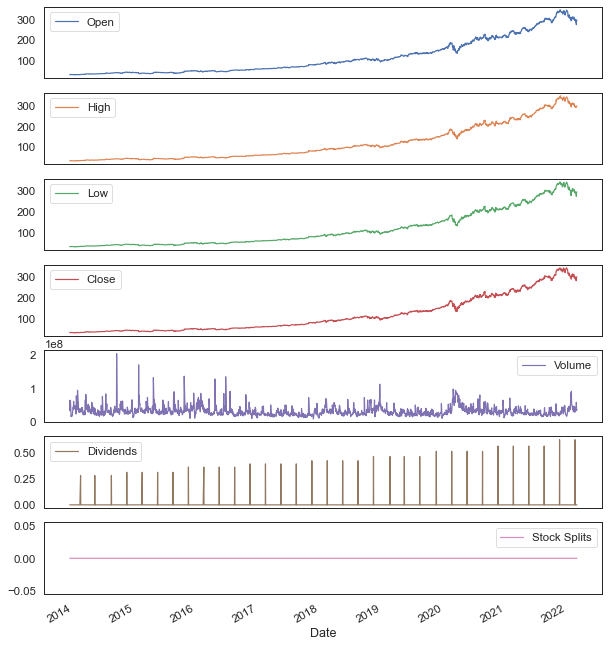

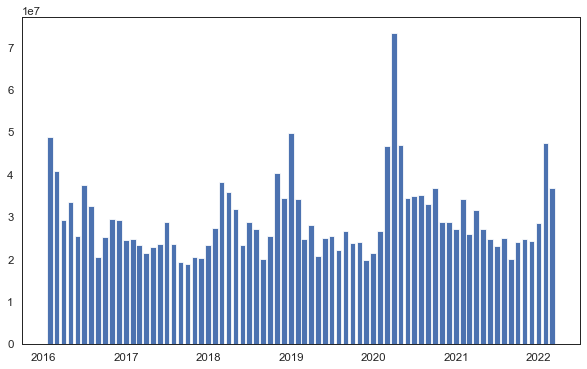

In [ ]:
msft = yf.Ticker("MSFT")

df = msft.history(period="max")
df = df.iloc[7000:]
dff = df.reset_index()
dff = dff['Date']
df.plot(subplots=True, figsize=(10,12))

df_month = df.resample("M").mean()
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df_month['2016':].index, df_month.loc['2016':, "Volume"], width=25, align='center')



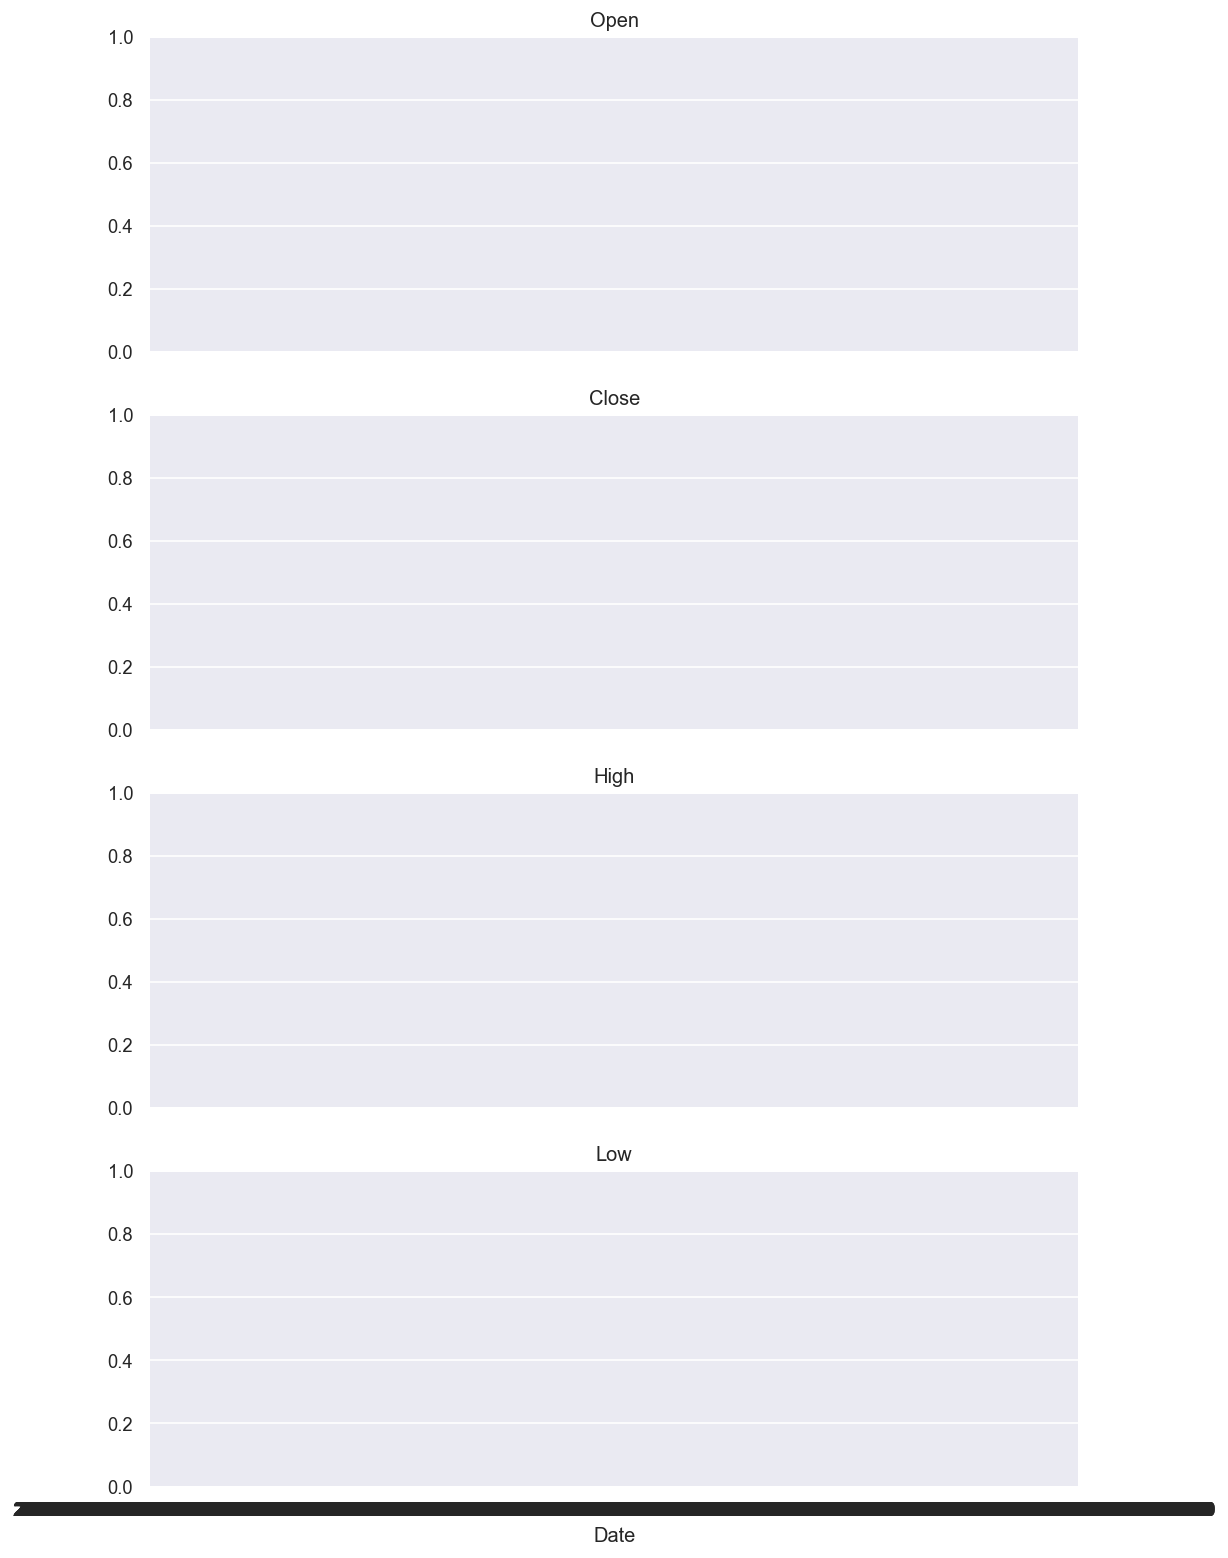

In [ ]:
start, end = '2016-01', '2016-12'
fig, axes = plt.subplots(4, 1, figsize=(10, 16), sharex=True)
for name, ax in zip(['Open', 'Close', 'High', 'Low'], axes):
    sns.boxplot(data = df, x=dff, y=name, ax=ax)
    ax.set_ylabel("")
    ax.set_title(name)
    if ax != axes[-1]:
        ax.set_xlabel('')


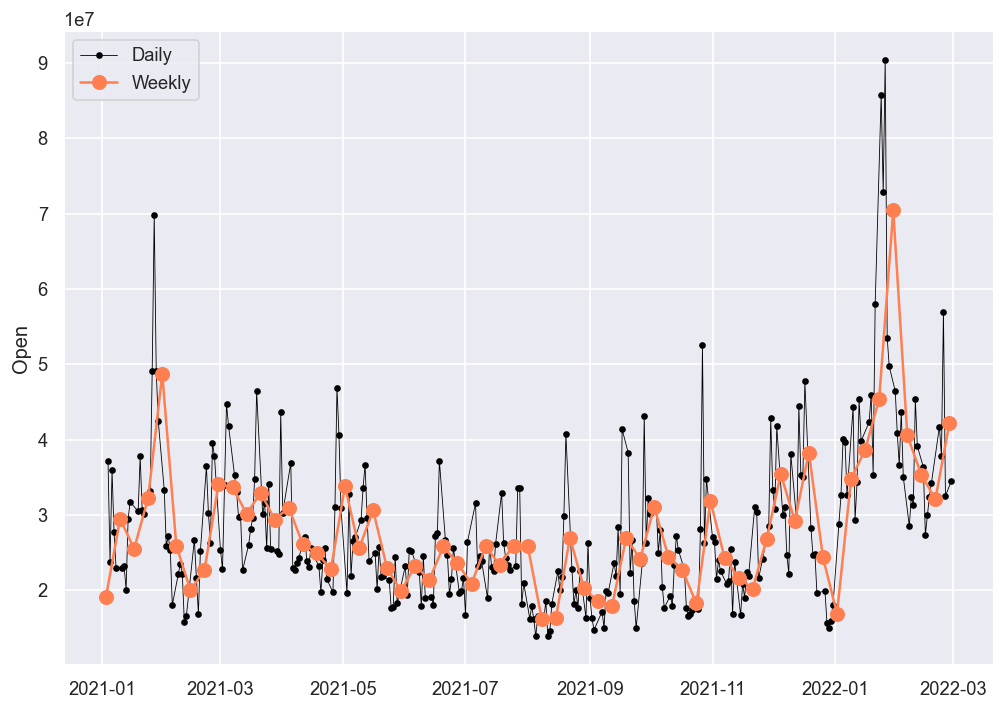

In [ ]:
df_week = df.resample("W").mean()
start, end = '2021-01', '2022-02'
fig, ax = plt.subplots()
ax.plot(df.loc[start:end, 'Volume'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(df_week.loc[start:end, 'Volume'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
label='Monthly'
color='violet'
ax.set_ylabel("Open")
ax.legend()


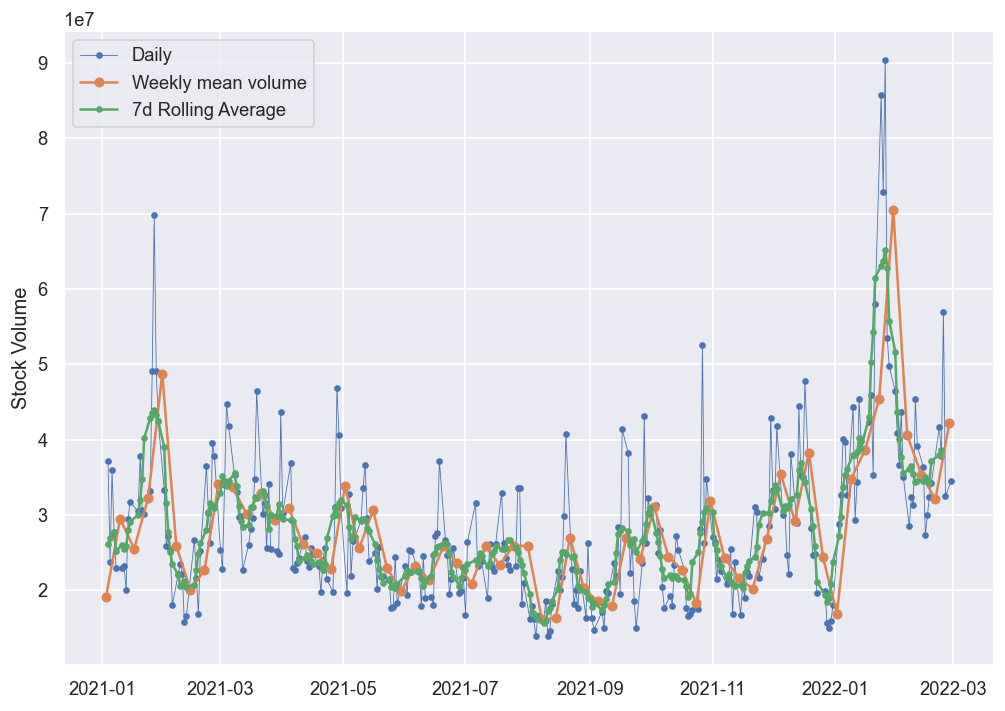

In [ ]:
df_7d_rolling = df.rolling(7, center=True).mean()
start, end = '2021-01', '2022-02'
fig, ax = plt.subplots()
ax.plot(df.loc[start:end, 'Volume'], marker='.', linestyle='-', 
        linewidth=0.5, label='Daily')
ax.plot(df_week.loc[start:end, 'Volume'], marker='o', markersize=5, 
        linestyle='-', label = 'Weekly mean volume')
ax.plot(df_7d_rolling.loc[start:end, 'Volume'], marker='.', linestyle='-', label='7d Rolling Average')
ax.set_ylabel('Stock Volume')
ax.legend()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='Date'>

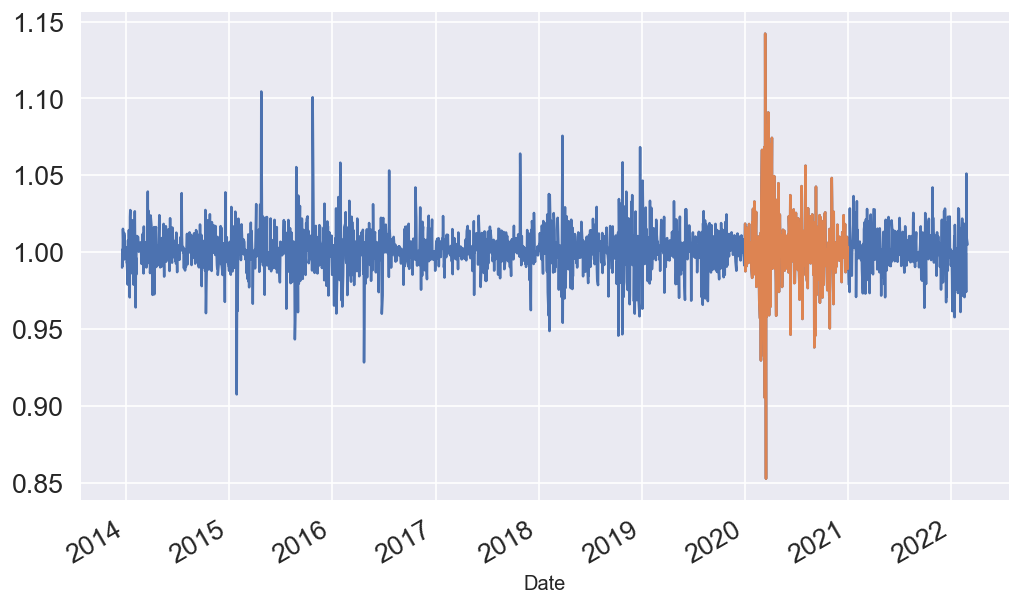

In [ ]:
df['Change'] = df.Close.div(df.Close.shift())
df['Change'].plot(figsize=(20, 8), fontsize = 16)

df['2020']['Change'].plot(figsize=(10, 6))


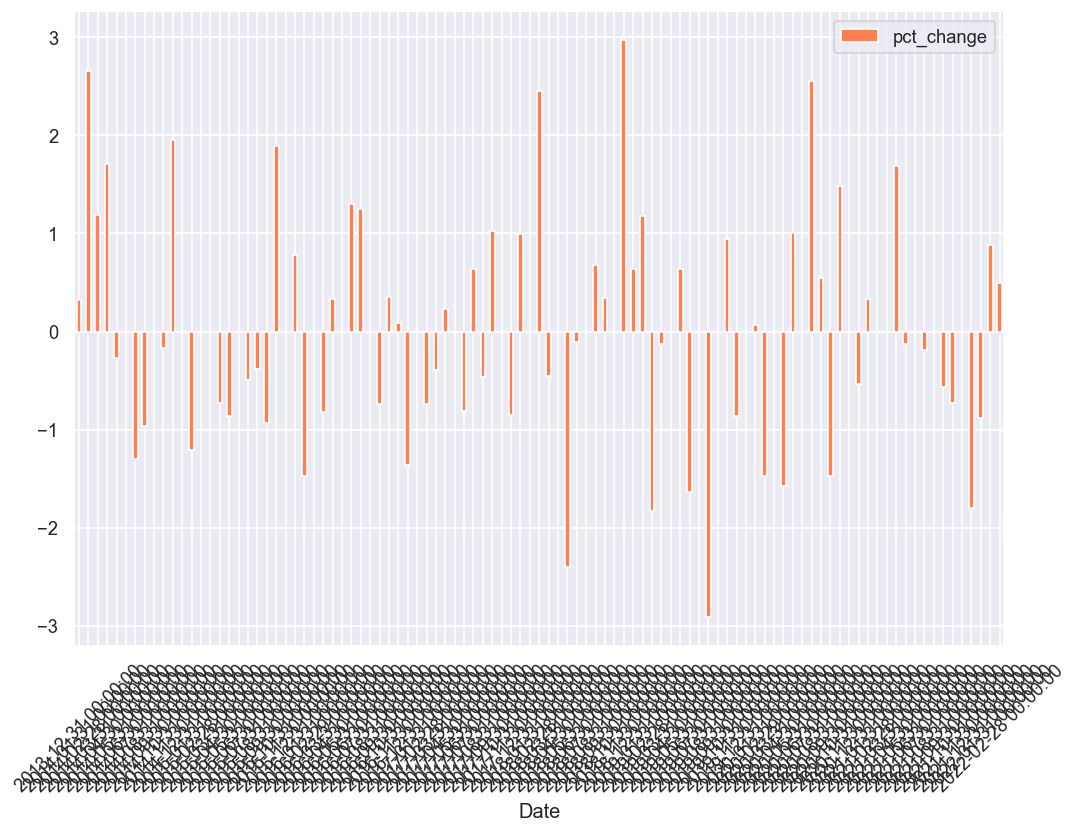

In [ ]:
df_month.loc[:, 'pct_change'] = df.Close.pct_change()*100
fig, ax = plt.subplots()
df_month['pct_change' ].plot(kind='bar', color='coral', ax=ax)
plt.xticks(rotation=45)
ax.legend()

<AxesSubplot:xlabel='Date'>

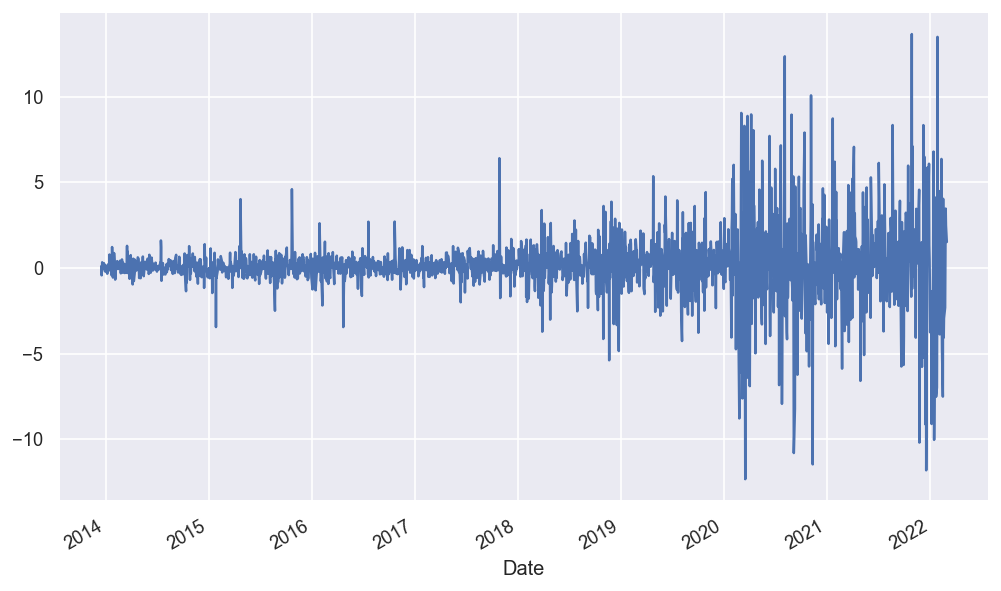

In [ ]:
df.High.diff().plot(figsize=(10, 6))


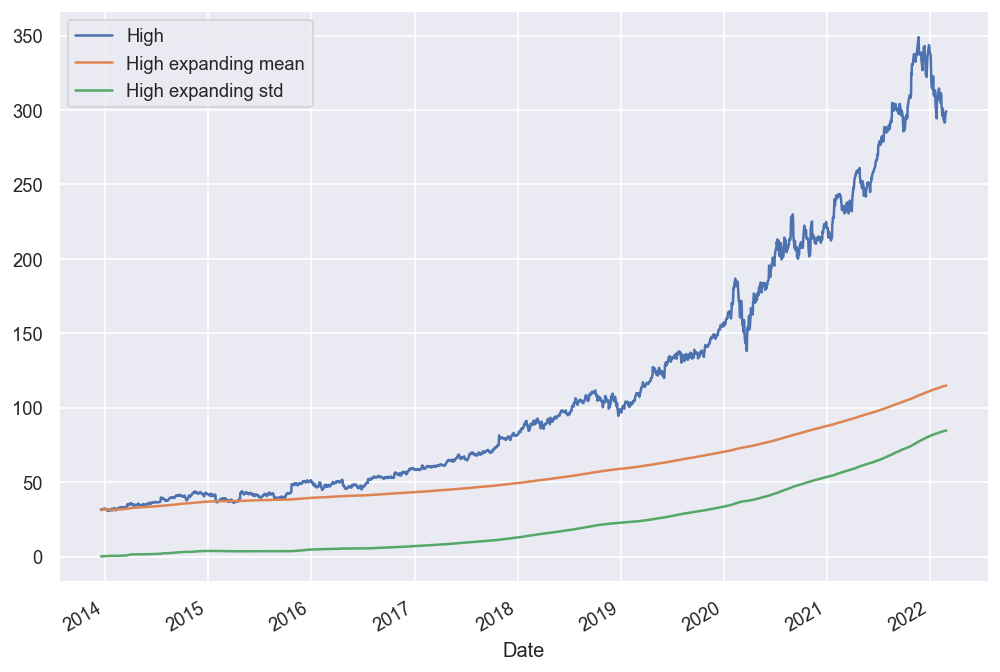

In [ ]:
fig, ax = plt.subplots()
ax = df.High.plot(label='High')
ax = df.High.expanding().mean().plot(label='High expanding mean')
ax = df.High.expanding().std().plot(label='High expanding std')
ax.legend()

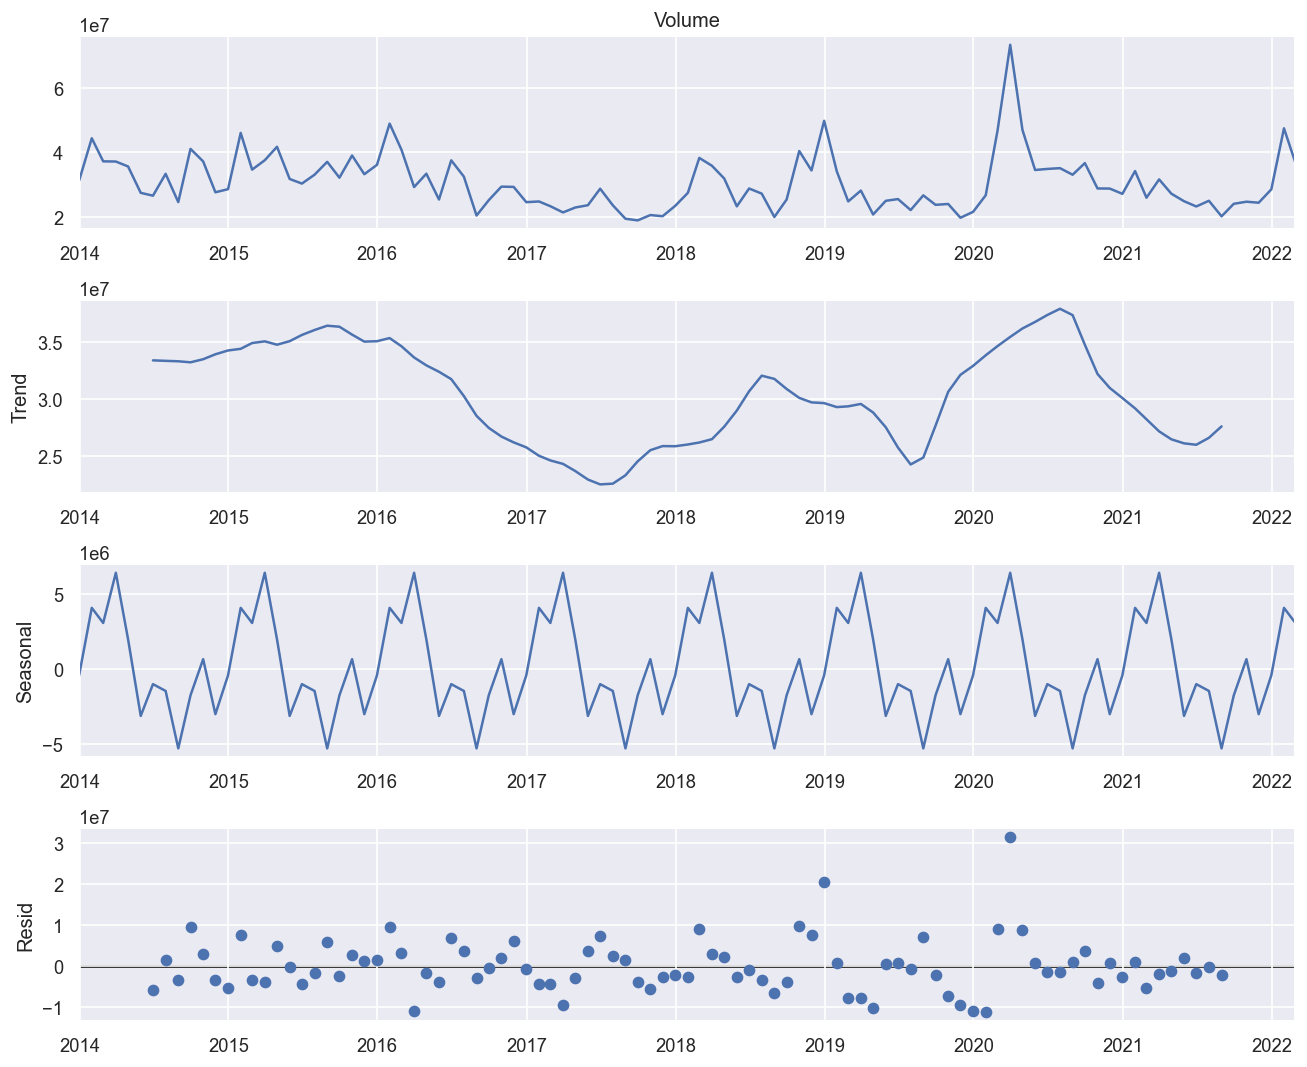

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(df_month['Volume'], model='Additive')
fig = decomposition.plot()
plt.show()


In [ ]:
hist=hist['Open'][(start_date <= hist.index) & (hist.index <= end_date)]




In [ ]:
fit1=SimpleExpSmoothing(hist).fit(smoothing_level=0.1,optimized=False)


//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
f = pd.DataFrame(fit1.fittedvalues)
f = f.reset_index()
data = f[0]

In [ ]:
print(fit1.aic, fit1.aicc, fit1.bic)

754.2245090333025 754.4745090333025 760.4363999811037


In [ ]:
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.100000,False
initial_level,l.0,276.420435,False


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df.head()


ValueError: Could not interpret value `timepoint` for parameter `x`

In [ ]:
fcast1=fit1.forecast(100)
fcast1

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


10     291.710392
11     291.710392
12     291.710392
13     291.710392
14     291.710392
          ...    
105    291.710392
106    291.710392
107    291.710392
108    291.710392
109    291.710392
Length: 100, dtype: float64

In [ ]:
start_date = datetime(2021,1,1)
end_date = datetime(2022,2,28)
hist=hist.set_index('Date')
hist.head(2)

,Open
Date,
2021-07-06,276.420435
2021-07-07,277.782487


In [ ]:
newdf=newdf['LL'][(start_date <= newdf.index) & (newdf.index <= end_date)]

NameError: name 'newdf' is not defined

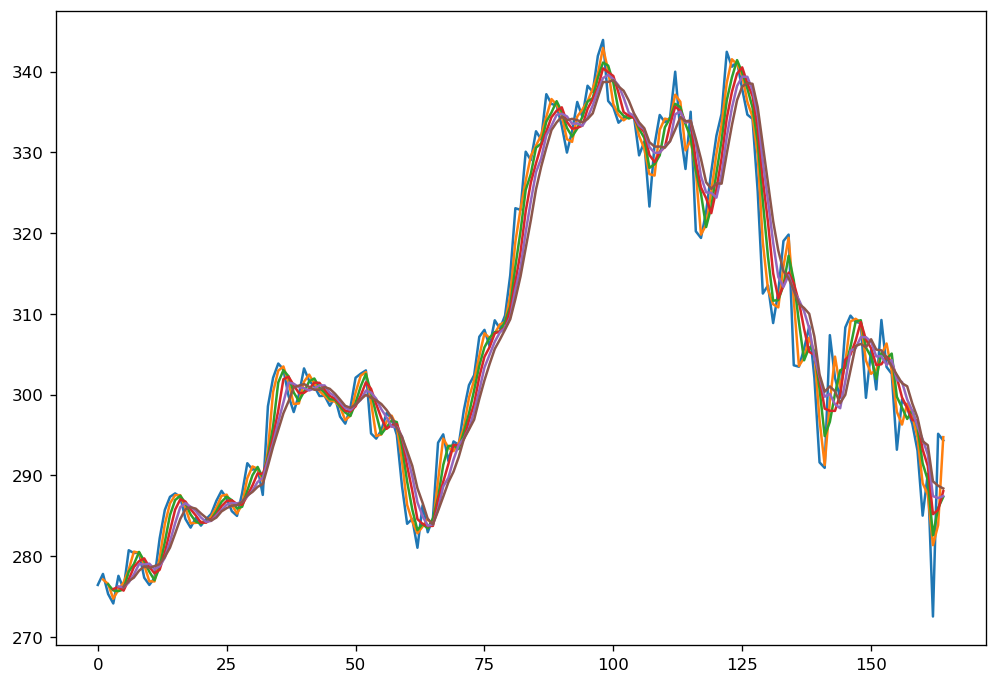

In [ ]:
msft = yf.Ticker("MSFT")

hist = msft.history(period="max")
hist = hist['Open'].iloc[8900:]
hist = pd.DataFrame(hist)
hist = hist.reset_index()
hist['Date'] = pd.to_datetime(hist['Date'])

plt.plot(hist.rolling(window=1).mean())
plt.plot(hist.rolling(window=2).mean())
plt.plot(hist.rolling(window=3).mean())
plt.plot(hist.rolling(window=4).mean())
plt.plot(hist.rolling(window=5).mean())
plt.plot(hist.rolling(window=6).mean())